In [1]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
from os import listdir
from os.path import isfile, join
import sys
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from matplotlib import patches
from matplotlib.collections import PatchCollection
#import matplotlib
from PIL import Image, ImageDraw
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib import pyplot
from skimage.color import rgb2gray, gray2rgb
from skimage.filters import threshold_otsu
from skimage.draw import polygon
from shapely.geometry.polygon import Polygon as Polygon_shapley
# from multiprocessing import Pool
import multiprocessing
from math import sqrt
import time
import random
import pickle
import png
from scipy.spatial import ConvexHull
import bbox_visualizer as bbv
import operator
import fileinput
import re

sys.path.insert(0, os.path.dirname(os.path.abspath('.'))) # to make imports relative to project root work

np.random.seed(0)

In [78]:
path_fit_to_circle = '../data/Thick_Smears_150/fit_to_circle'
path_cropped = '../data/Thick_Smears_150/cropped'

# Check Bounding Boxex NIH

First download files from ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/Thick_Smears_150 to folder (see the terminal comand below) e.g.

Thick_Smears_150 <br>
└-GT_updated <br>
└-Folders with images of thick blood smears <br>


In the Terminal navigate to the folder you want your data in (**cd** then drag and drop the folder) then enter following:

wget -r -np ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/Thick_Smears_150

(you might need to install wget with **brew install wget** and if you do not have brew then install homebrew https://brew.sh/)


In [254]:
def get_txt(path):
    list_txt = []
    # Delimiter
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".txt"):
                txt_path = os.path.join(root, file)
                list_txt.append(txt_path)
    return list_txt


def txt_to_df(path):
    data_file_delimiter = ','
    df = pd.DataFrame(columns = [ 'Img no - Cell no','cell', 'comment', 'annotation_type','Number of points', 'position', 'filename', 'txt_path', 'img_path'])
    root, file = os.path.split(path)
    filename, file_extension = os.path.splitext(file)
    txt_path = os.path.join(root, file)
    img_path = os.path.join(root.replace("GT_updated/", ""), filename +'.jpg')
    # Loop the data lines
    with open(txt_path, 'r') as temp_f:
        # Read the lines
        lines = temp_f.readlines()
        lines.pop(0)
        for l in lines:
            # Count the column count for the current line
            columns = l.split(data_file_delimiter)
            list_locations = [float(location) for location in columns[5:]]
            zip_locations = list(zip(list_locations[::2], list_locations[1::2]))
            df = df.append( {'Img no - Cell no': columns[0], 'cell': columns[1], 'comment': columns[2], 'annotation_type': columns[3], \
                'Number of points': columns[4], 'position': zip_locations, 'filename': filename, 'txt_path': txt_path, 'img_path': img_path}, ignore_index = True)
    return df

def collect_results(df_collected):
    """Uses apply_async's callback to setup up a separate Queue for each process"""
    global df
    df = df.append(df_collected)


In [273]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def draw_points(img, cell, annotation, position, row, rows = 1, columns = 1, i = 1, point_size = 15):
    colour = (0,255,0) if cell == 'Uninfected' \
        else (255,0, 0) if cell == 'Parasite' \
            else (255,0, 0) if cell == 'Parasitized' \
                else (128,0, 128) if cell == 'Platelet' \
                    else (0, 0, 255) if cell == 'White_Blood_Cell' \
                        else (255,215,0)

    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(row['filename'])

    if annotation == 'Point':
        x = position[0][0] 
        y = position[0][1] 
        cv2.circle(img, (int(x),int(y)), 1, colour, point_size)
    
    if annotation == 'Circle':
        x1 = position[0][0] 
        y1 = position[0][1] 
        x2 = position[1][0] 
        y2 = position[1][1] 
        radius = int(sqrt( (x2 - x1)**2 + (y2 - y1)**2 )) # distance from circle center to point on circle
        cv2.circle(img, (int(x1),int(y1)), radius, colour, 7)
    
    elif annotation == 'Polygon':
        if len(position) < 3:
            print('row: ', row)
        if not len(position) < 3:
            poly = Polygon_shapley(position)
            x,y = poly.exterior.xy
            ax.plot(x, y, color=rgb_to_hex(colour), alpha=0.7,
                linewidth=3, solid_capstyle='round', zorder=2)


In [256]:
txt_list = get_txt('../data/Thick_Smears_150/GT_updated/')
print(len(txt_list))

2206


**The following operation takes a while lean back and get a coffee**

In [257]:
df = pd.DataFrame(columns = [ 'Img no - Cell no','cell', 'comment', 'annotation_type','Number of points', 'position', 'filename', 'txt_path', 'img_path'])
start_time = time.time()  

# Repeats the compute intensive operation on all available cores
pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
pool.map_async(txt_to_df, txt_list, callback = collect_results)
pool.close()
pool.join()

# Converts list of lists to a data frame
print(df.shape)
print("--- %s seconds ---" % (time.time() - start_time))

(120441, 9)
--- 107.59146785736084 seconds ---


In [258]:
def get_bbx(position, annotation_type, bb_pixel):
    if annotation_type == 'Polygon':
        poly_list = np.array([list(ele) for ele in position])
        x_min = np.nanmin(poly_list[:, 0])
        x_max = np.nanmax(poly_list[:, 0])
        y_min = np.nanmin(poly_list[:, 1])
        y_max = np.nanmax(poly_list[:, 1])
        return [x_min, y_min, x_max, y_max]
    if annotation_type == 'Point':
        point_list = np.array(position)
        x_min = int(point_list[:, 0] - 0.5 * bb_pixel)
        x_max = int(point_list[:, 0] + 0.5 * bb_pixel)
        y_min = int(point_list[:, 1] - 0.5 * bb_pixel)
        y_max = int(point_list[:, 1] + 0.5 * bb_pixel)
        return [x_min, y_min, x_max, y_max]
    if annotation_type == 'Circle':
        x1 = position[0][0] 
        y1 = position[0][1] 
        x2 = position[1][0] 
        y2 = position[1][1] 
        radius = int(sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        x_min = int(x1 - 0.5 * radius)
        x_max = int(x1 + 0.5 * radius)
        y_min = int(y1 - 0.5 * radius)
        y_max = int(y1 + 0.5 * radius)
        return [x_min, y_min, x_max, y_max]
    

In [259]:
df['bbx'] = df.apply(lambda row: get_bbx(row['position'], row['annotation_type'], 140), axis = 1)
df

Img no - Cell no              cell     comment annotation_type  \
0               7-1          Parasite  No_Comment          Circle   
1              7-10          Parasite  No_Comment          Circle   
2              7-11          Parasite  No_Comment          Circle   
3              7-12          Parasite  No_Comment          Circle   
4              7-13          Parasite  No_Comment          Circle   
..              ...               ...         ...             ...   
35             8-36  White_Blood_Cell  No_Comment           Point   
36             8-37  White_Blood_Cell  No_Comment           Point   
37             8-38  White_Blood_Cell  No_Comment           Point   
38             8-39  White_Blood_Cell  No_Comment           Point   
39             8-40  White_Blood_Cell  No_Comment           Point   

   Number of points                                position         filename  \
0                 2   [(2787.45, 678.15), (2787.45, 703.2)]  20170812_171245   
1                 2  [(2862.5, 1454.85), (2850.05, 1475.8)]  20170812_171245   
2                 2   [(2729.1, 1429.85), (2720.8, 1453.4)]  20170812_171245   
3                 2   [(2674.9, 1545.2), (2670.75, 1563.3)]  20170812_171245   
4                 2   [(2904.2, 1595.25), (2904.2, 1616.1)]  20170812_171245   
..              ...                                     ...              ...   
35                1                     [(1105.2, 2498.85)]  20170829_204418   
36                1                     [(1368.6, 2311.25)]  20170829_204418   
37                1                    [(1477.25, 2406.75)]  20170829_204418   
38                1                     [(1743.85, 2633.9)]  20170829_204418   
39                1                      [(2351.7, 2562.7)]  20170829_204418   

                                             txt_path  \
0   ../data/Thick_Smears_150/GT_updated/TF53_CW41/...   
1   ../data/Thick_Smears_150/GT_updated/TF53_CW41/...   
2   ../data/Thick_Smears_150/GT_updated/TF53_CW41/...   
3   ../data/Thick_Smears_150/GT_updated/TF53_CW41/...   
4   ../data/Thick_Smears_150/GT_updated/TF53_CW41/...   
..                                                ...   
35  ../data/Thick_Smears_150/GT_updated/TF99_CS40/...   
36  ../data/Thick_Smears_150/GT_updated/TF99_CS40/...   
37  ../data/Thick_Smears_150/GT_updated/TF99_CS40/...   
38  ../data/Thick_Smears_150/GT_updated/TF99_CS40/...   
39  ../data/Thick_Smears_150/GT_updated/TF99_CS40/...   

                                             img_path  \
0   ../data/Thick_Smears_150/TF53_CW41/20170812_17...   
1   ../data/Thick_Smears_150/TF53_CW41/20170812_17...   
2   ../data/Thick_Smears_150/TF53_CW41/20170812_17...   
3   ../data/Thick_Smears_150/TF53_CW41/20170812_17...   
4   ../data/Thick_Smears_150/TF53_CW41/20170812_17...   
..                                                ...   
35  ../data/Thick_Smears_150/TF99_CS40/20170829_20...   
36  ../data/Thick_Smears_150/TF99_CS40/20170829_20...   
37  ../data/Thick_Smears_150/TF99_CS40/20170829_20...   
38  ../data/Thick_Smears_150/TF99_CS40/20170829_20...   
39  ../data/Thick_Smears_150/TF99_CS40/20170829_20...   

                         bbx  
0     [2774, 665, 2799, 690]  
1   [2850, 1442, 2874, 1466]  
2   [2717, 1417, 2741, 1441]  
3   [2665, 1536, 2683, 1554]  
4   [2894, 1585, 2914, 1605]  
..                       ...  
35  [1035, 2428, 1175, 2568]  
36  [1298, 2241, 1438, 2381]  
37  [1407, 2336, 1547, 2476]  
38  [1673, 2563, 1813, 2703]  
39  [2281, 2492, 2421, 2632]  

[120441 rows x 10 columns]

In [260]:
fake_patient_id = {}
counter = 300
def get_patient_id_path(path):
    '''function takes path to get patient ID,
    when patient ID is not available from path, take fake patient ID'''
    global counter
    try:
        return int(re.search('P[0-9]*N', path).group(0)[1:])
    except Exception as e:
        path_patient_folder = re.search('.*/Thick_Smears_150/(.*?)\/', path).group(0)
        #print(path_patient_folder)
        try:
            return fake_patient_id[path_patient_folder]
        except:
            counter += 1
            fake_patient_id[path_patient_folder] = counter
            return counter
            

In [261]:
df['patient_n_path'] = df['img_path'].apply(lambda row: get_patient_id_path(row))

In [262]:
len(df['patient_n_path'].unique())

150

In [263]:
df.loc[(df['annotation_type'] == 'Point')].groupby('filename').count().sort_values(by = 'img_path')

Img no - Cell no  cell  comment  annotation_type  \
filename                                                            
20170820_104144                 6     6        6                6   
20170831_104805                 7     7        7                7   
20170724_171355                 7     7        7                7   
20170820_143038                 7     7        7                7   
20170612_155404                 8     8        8                8   
...                           ...   ...      ...              ...   
20170831_094745                83    83       83               83   
20170830_113814                84    84       84               84   
20170830_114554                87    87       87               87   
20170831_094603                87    87       87               87   
20170820_152301                87    87       87               87   

                 Number of points  position  txt_path  img_path  bbx  \
filename                                                               
20170820_104144                 6         6         6         6    6   
20170831_104805                 7         7         7         7    7   
20170724_171355                 7         7         7         7    7   
20170820_143038                 7         7         7         7    7   
20170612_155404                 8         8         8         8    8   
...                           ...       ...       ...       ...  ...   
20170831_094745                83        83        83        83   83   
20170830_113814                84        84        84        84   84   
20170830_114554                87        87        87        87   87   
20170831_094603                87        87        87        87   87   
20170820_152301                87        87        87        87   87   

                 patient_n_path  
filename                         
20170820_104144               6  
20170831_104805               7  
20170724_171355               7  
20170820_143038               7  
20170612_155404               8  
...                         ...  
20170831_094745              83  
20170830_113814              84  
20170830_114554              87  
20170831_094603              87  
20170820_152301              87  

[1833 rows x 10 columns]

In [264]:
# df = pd.read_csv(gt_path, sep = ',', header = 0, names= [ '?','cell', 'comment', 'annotation_type','??', 'y', 'x'])
df['cell'].value_counts()

Parasite            84961
White_Blood_Cell    35480
Name: cell, dtype: int64

In [265]:
df_points = df[df['annotation_type'] == 'Point']
df_points.groupby(['filename']).count()['cell'].mean()

19.355155482815057

In [266]:
filename =   '20170830_170322' #'20170830_170535' #'20170820_152301' #'20170830_114554' #'20170831_104805' #'20170820_104144' #'20170724_171355' #'IMG_20150623_134547' 
df_file = df[df['filename'] == filename]
df_file.head()

Img no - Cell no      cell     comment annotation_type Number of points  \
0              3-1  Parasite  No_Comment          Circle                2   
1             3-10  Parasite  No_Comment          Circle                2   
2             3-11  Parasite  No_Comment          Circle                2   
3             3-13  Parasite  No_Comment          Circle                2   
4             3-14  Parasite  No_Comment          Circle                2   

                                position         filename  \
0  [(2745.95, 565.85), (2752.45, 588.6)]  20170830_170322   
1  [(2024.05, 474.05), (2030.1, 501.45)]  20170830_170322   
2     [(2002.6, 768.3), (2002.6, 768.3)]  20170830_170322   
3    [(2089.3, 324.25), (2099.7, 339.9)]  20170830_170322   
4    [(1263.7, 616.15), (1263.7, 631.4)]  20170830_170322   

                                            txt_path  \
0  ../data/Thick_Smears_150/GT_updated/TF110_270/...   
1  ../data/Thick_Smears_150/GT_updated/TF110_270/...   
2  ../data/Thick_Smears_150/GT_updated/TF110_270/...   
3  ../data/Thick_Smears_150/GT_updated/TF110_270/...   
4  ../data/Thick_Smears_150/GT_updated/TF110_270/...   

                                            img_path                     bbx  \
0  ../data/Thick_Smears_150/TF110_270/20170830_17...  [2734, 554, 2757, 577]   
1  ../data/Thick_Smears_150/TF110_270/20170830_17...  [2010, 460, 2038, 488]   
2  ../data/Thick_Smears_150/TF110_270/20170830_17...  [2002, 768, 2002, 768]   
3  ../data/Thick_Smears_150/TF110_270/20170830_17...  [2080, 315, 2098, 333]   
4  ../data/Thick_Smears_150/TF110_270/20170830_17...  [1256, 608, 1271, 623]   

   patient_n_path  
0             322  
1             322  
2             322  
3             322  
4             322

In [267]:
df_file[df_file['position'].str.len() > 0]

Img no - Cell no              cell     comment annotation_type  \
0                3-1          Parasite  No_Comment          Circle   
1               3-10          Parasite  No_Comment          Circle   
2               3-11          Parasite  No_Comment          Circle   
3               3-13          Parasite  No_Comment          Circle   
4               3-14          Parasite  No_Comment          Circle   
..               ...               ...         ...             ...   
118             3-95  White_Blood_Cell  No_Comment           Point   
119             3-96  White_Blood_Cell  No_Comment           Point   
120             3-97  White_Blood_Cell  No_Comment           Point   
121             3-98  White_Blood_Cell  No_Comment           Point   
122             3-99  White_Blood_Cell  No_Comment           Point   

    Number of points                               position         filename  \
0                  2  [(2745.95, 565.85), (2752.45, 588.6)]  20170830_170322   
1                  2  [(2024.05, 474.05), (2030.1, 501.45)]  20170830_170322   
2                  2     [(2002.6, 768.3), (2002.6, 768.3)]  20170830_170322   
3                  2    [(2089.3, 324.25), (2099.7, 339.9)]  20170830_170322   
4                  2    [(1263.7, 616.15), (1263.7, 631.4)]  20170830_170322   
..               ...                                    ...              ...   
118                1                    [(1091.1, 1695.65)]  20170830_170322   
119                1                     [(784.55, 1662.3)]  20170830_170322   
120                1                    [(1951.15, 1802.3)]  20170830_170322   
121                1                     [(1797.8, 1849.0)]  20170830_170322   
122                1                    [(2011.2, 2022.35)]  20170830_170322   

                                              txt_path  \
0    ../data/Thick_Smears_150/GT_updated/TF110_270/...   
1    ../data/Thick_Smears_150/GT_updated/TF110_270/...   
2    ../data/Thick_Smears_150/GT_updated/TF110_270/...   
3    ../data/Thick_Smears_150/GT_updated/TF110_270/...   
4    ../data/Thick_Smears_150/GT_updated/TF110_270/...   
..                                                 ...   
118  ../data/Thick_Smears_150/GT_updated/TF110_270/...   
119  ../data/Thick_Smears_150/GT_updated/TF110_270/...   
120  ../data/Thick_Smears_150/GT_updated/TF110_270/...   
121  ../data/Thick_Smears_150/GT_updated/TF110_270/...   
122  ../data/Thick_Smears_150/GT_updated/TF110_270/...   

                                              img_path  \
0    ../data/Thick_Smears_150/TF110_270/20170830_17...   
1    ../data/Thick_Smears_150/TF110_270/20170830_17...   
2    ../data/Thick_Smears_150/TF110_270/20170830_17...   
3    ../data/Thick_Smears_150/TF110_270/20170830_17...   
4    ../data/Thick_Smears_150/TF110_270/20170830_17...   
..                                                 ...   
118  ../data/Thick_Smears_150/TF110_270/20170830_17...   
119  ../data/Thick_Smears_150/TF110_270/20170830_17...   
120  ../data/Thick_Smears_150/TF110_270/20170830_17...   
121  ../data/Thick_Smears_150/TF110_270/20170830_17...   
122  ../data/Thick_Smears_150/TF110_270/20170830_17...   

                          bbx  patient_n_path  
0      [2734, 554, 2757, 577]             322  
1      [2010, 460, 2038, 488]             322  
2      [2002, 768, 2002, 768]             322  
3      [2080, 315, 2098, 333]             322  
4      [1256, 608, 1271, 623]             322  
..                        ...             ...  
118  [1021, 1625, 1161, 1765]             322  
119    [714, 1592, 854, 1732]             322  
120  [1881, 1732, 2021, 1872]             322  
121  [1727, 1779, 1867, 1919]             322  
122  [1941, 1952, 2081, 2092]             322  

[123 rows x 11 columns]

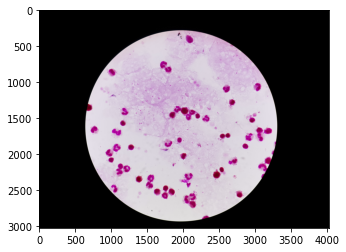

In [268]:
cv2.IMREAD_IGNORE_ORIENTATION = 128
img = cv2.imread(df_file['img_path'].iloc[-1], flags=cv2.IMREAD_IGNORE_ORIENTATION|cv2.IMREAD_COLOR)
#img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
#img = cv2.flip(img, 1)
#img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

plt.imshow(img)

In [269]:
# cv2.circle(img, df_file['position'][240][0], 1, (0,255,0), 50)
# plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


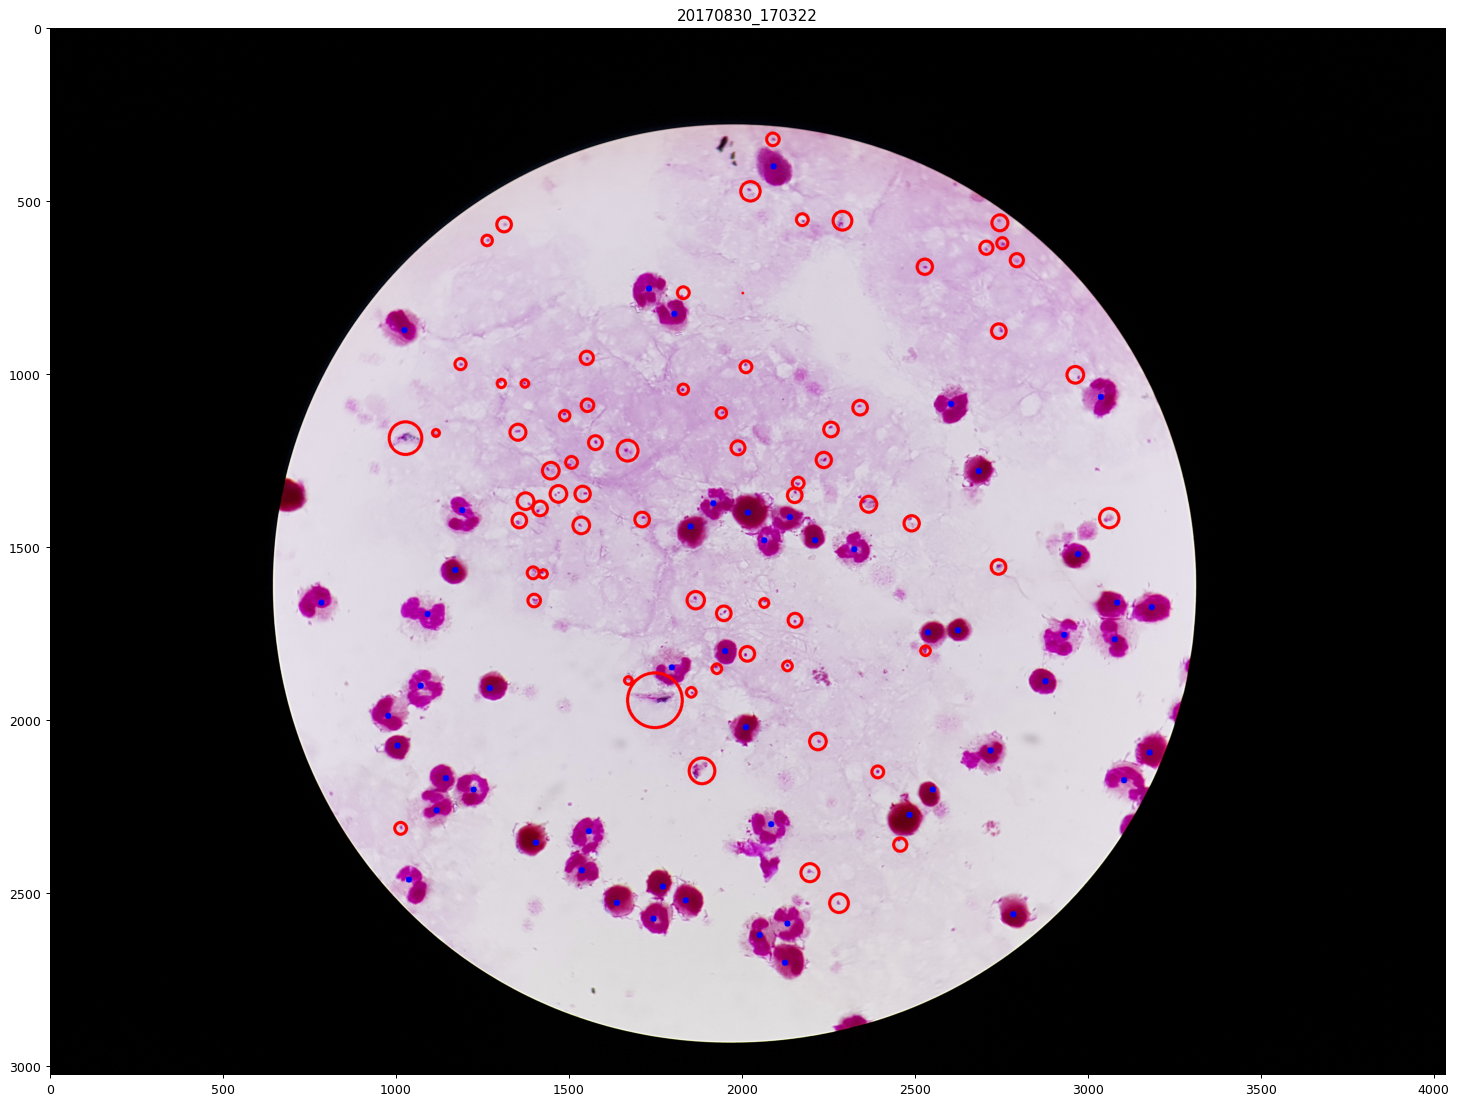

In [274]:
fig = plt.figure(1, figsize=(20,20), dpi=90)
df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row), axis = 1)
plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


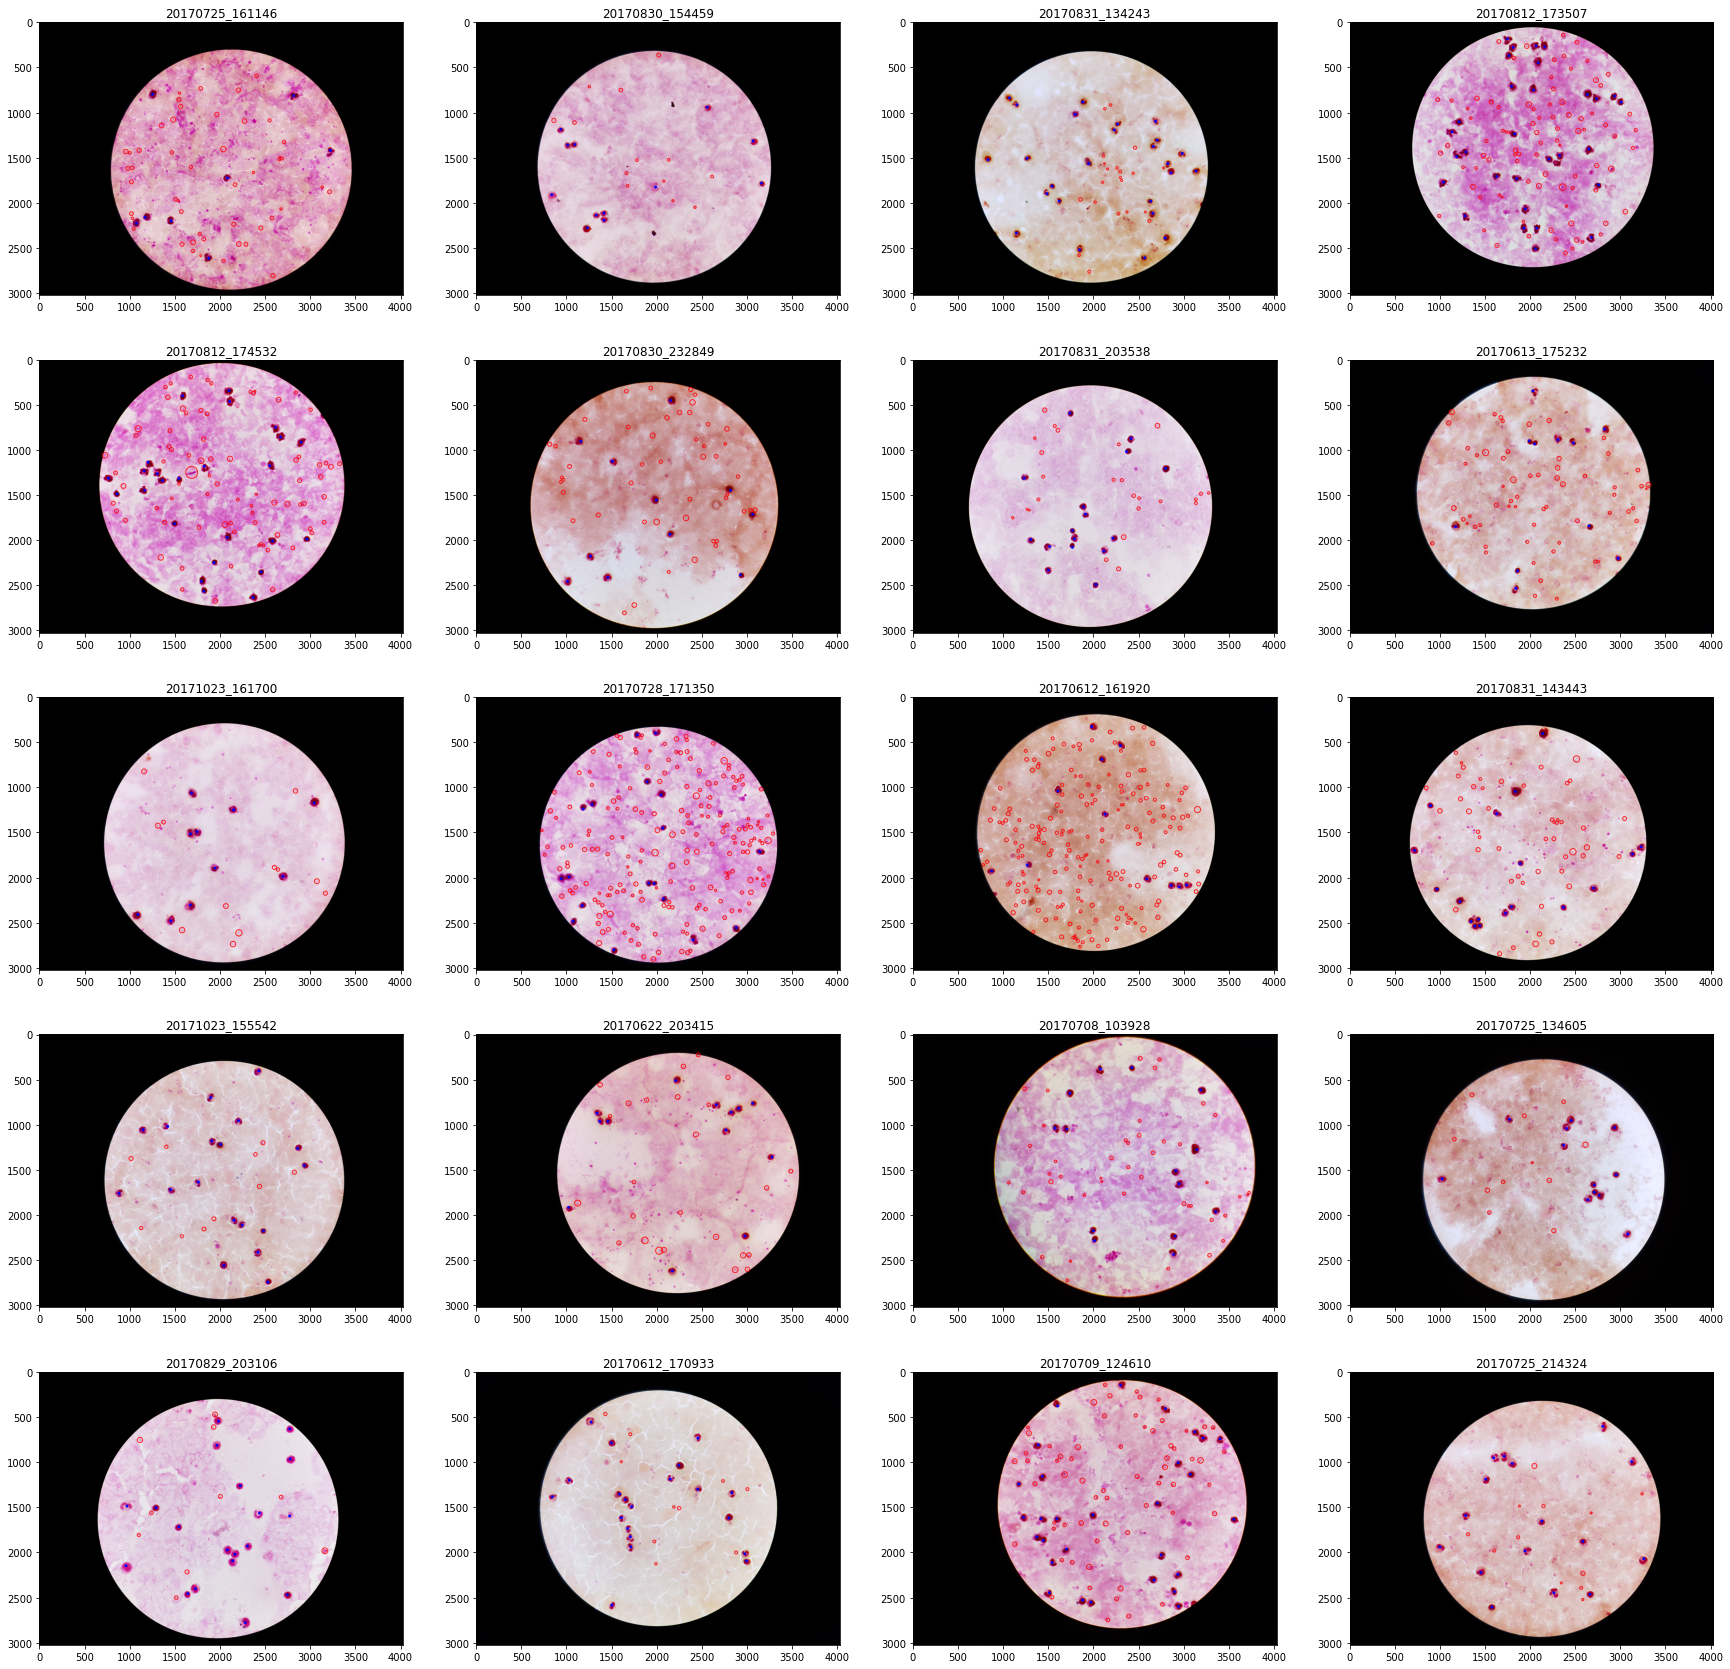

In [275]:
secure_random = random.SystemRandom()

w, h = 10, 10
fig=plt.figure(figsize=(30, 30))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    filename = secure_random.choice(df['filename'].unique())
    df_file = df[df['filename'] == filename]
    #print(filename)
    img = cv2.imread(df_file['img_path'].iloc[-1], flags=cv2.IMREAD_IGNORE_ORIENTATION|cv2.IMREAD_COLOR)
    #img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row = row, rows = rows, columns = columns, i = i, point_size= 30), axis = 1)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Cutting and tiling images and labels

(4032, 3024)


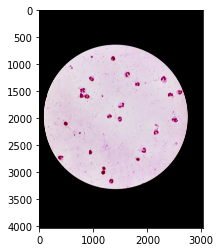

In [21]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
resize_factor = 1
print(img.shape[:2])
resized_img = cv2.resize(img, (int(round(img.shape[1] * resize_factor)), int(round(img.shape[0] * resize_factor))), interpolation=cv2.INTER_AREA)
plt.imshow(resized_img)

In [22]:
df_file.head()

Img no - Cell no      cell     comment annotation_type Number of points  \
0              2-1  Parasite    schizont          Circle                2   
1             2-10  Parasite  No_Comment          Circle                2   
2            2-100  Parasite  No_Comment          Circle                2   
3            2-101  Parasite  No_Comment          Circle                2   
4            2-102  Parasite  No_Comment          Circle                2   

                       position         filename  \
0    [(1882, 550), (1876, 569)]  20170830_140656   
1    [(2521, 742), (2510, 764)]  20170830_140656   
2  [(1800, 2563), (1805, 2582)]  20170830_140656   
3  [(1764, 2625), (1766, 2643)]  20170830_140656   
4  [(1723, 2702), (1725, 2722)]  20170830_140656   

                                            txt_path  \
0  ../data/Thick_Smears_150/GT_updated/TF105_245/...   
1  ../data/Thick_Smears_150/GT_updated/TF105_245/...   
2  ../data/Thick_Smears_150/GT_updated/TF105_245/...   
3  ../data/Thick_Smears_150/GT_updated/TF105_245/...   
4  ../data/Thick_Smears_150/GT_updated/TF105_245/...   

                                            img_path  \
0  ../data/Thick_Smears_150/TF105_245/20170830_14...   
1  ../data/Thick_Smears_150/TF105_245/20170830_14...   
2  ../data/Thick_Smears_150/TF105_245/20170830_14...   
3  ../data/Thick_Smears_150/TF105_245/20170830_14...   
4  ../data/Thick_Smears_150/TF105_245/20170830_14...   

                        bbx  patient_n_path  
0    [1872, 540, 1891, 559]             412  
1    [2509, 730, 2533, 754]             412  
2  [1790, 2553, 1809, 2572]             412  
3  [1755, 2616, 1773, 2634]             412  
4  [1713, 2692, 1733, 2712]             412

## Cut fit to circle

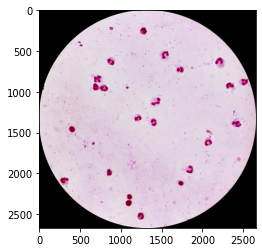

In [23]:
# select circle only
img_gray = rgb2gray(resized_img)
th = threshold_otsu(img_gray)
fg = img_gray>th
# Find the bounding box of those pixels
coords = np.array(np.nonzero(fg))
top_left = np.min(coords, axis=1)
bottom_right = np.max(coords, axis=1)

# #set all under threshhold values to zero 
# img_circle = resized_img*gray2rgb(fg)
img_circle = resized_img

img_cropped = img_circle[top_left[0]:bottom_right[0],
            top_left[1]:bottom_right[1]]

plt.imshow(img_cropped)

In [38]:
def adjust_poly_coord(poly_coords, removed_left, removed_top):
    '''returns a list of polgones with adjusted coordinates'''
    return [(poly[0] - removed_left, poly [1] - removed_top) for poly in poly_coords]
        
def circle_crop(img_path):
    '''returns a cropped image according to the circle as well as the removed top part and removed left part of the image'''
    img = cv2.imread(img_path, flags=cv2.IMREAD_IGNORE_ORIENTATION|cv2.IMREAD_COLOR)

    # select circle only
    img_gray = rgb2gray(img)
    th = threshold_otsu(img_gray)
    fg = img_gray>th
    # Find the bounding box of those pixels
    coords = np.array(np.nonzero(fg))
    min_coords = np.min(coords, axis=1) # [y1, x1]
    max_coords = np.max(coords, axis=1) # [y2, x2]
    
    print('min_coords:', min_coords)
    print('max_coords:', max_coords)
    
    if img_path in dict_poly:
        list_list_tuples_poly = dict_poly[img_path]
        list_tuples_poly = [item for sublist in list_list_tuples_poly for item in sublist]
        list_poly = list(sum(list_tuples_poly, ()))
        x = list_poly[0::2]
        y = list_poly[1::2]
        
        if min(y) < min_coords[0]:
            min_coords[0] = min(y)
        if min(x) < min_coords[1]:
            min_coords[1] = min(x)
        if max(y) > max_coords[0]:
            max_coords[0] = max(y)
        if max(x) > max_coords[1]:
            max_coords[1] = max(x)
            
        print('img_shape: ', img.shape)
        print('new min_coords:', min_coords)
        print('new max_coords:', max_coords)
        print('x min, x max: ', min(x), max(x))
        print('y min, y max: ', min(y), max(y))
    
    #set all under threshhold values to zero 
    #img_circle = img*gray2rgb(fg)
    
    ''' image[start_row:end_row, start_column:end_column] e.g. image[30:250, 100:230] or [x1:x2, y1:y2]
    You can see that the waterfall goes vertically starting at about 30px and ending at around 250px.
    You can see that the waterfall goes horizontally from around 100px to around 230px. 
                '''

    img_cropped = img[min_coords[0]:max_coords[0],
                min_coords[1]:max_coords[1]]
    
    return img_cropped, min_coords[0], min_coords[1]

In [39]:
def adjust_coordinates(img_path, position):
    '''returns adjusted coordinates and fitted circle img path '''
    removed_top, removed_left, outname_im = dict_rmv_fit_to_circle[img_path]
    adjusted_polys = adjust_poly_coord(position, removed_left, removed_top)
    return adjusted_polys


In [40]:
def poly2mask(filename, img_path = 'img_path', out_path = '../data/masks', poly_position = 'position'):
    img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), img_path].iloc[-1], cv2.IMREAD_COLOR)
    img = Image.new("L", [img.shape[1], img.shape[0]], 0)
    img = img.convert('1')
    [ ImageDraw.Draw(img).polygon(poly, outline=0, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), poly_position]]

    
    if not os.path.isdir(out_path):
        os.makedirs(out_path)

    mask_path = f'{out_path}/mask_{filename}.png'
    img.save(mask_path)
    return mask_path

def poly2multimask(filename, img_path = 'img_path', out_path = '../data/fit_to_circle', poly_position = 'adjusted_position', outname_mask = False):
    # fill index number per polygon
    img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), img_path].iloc[-1], cv2.IMREAD_COLOR)
    np_img = np.zeros(shape=[img.shape[0], img.shape[1], 1], dtype=np.uint16)

    # This gets polygons filled with an index number
    for index, poly in enumerate(df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), poly_position]):
        poly = np.array(poly)
        rr, cc = polygon(poly[::,1], poly[::,0])
        np_img[rr, cc] = index
    
    #np_img = np_img.astype(np.uint16) if np_img.max()<2**16-1 else np_img.astype(np.uint32)
        
    if not os.path.isdir(out_path):
        os.makedirs(out_path)    
    
    if outname_mask:
        cv2.imwrite(outname_mask, np_img)
    else:    
        outname_mask = f'{outname_mask}/mask_{filename}.png'
        cv2.imwrite(outname_mask, np_img)
    return outname_mask

In [41]:
check_if_outdir_im_circle = os.path.isdir(path_fit_to_circle)

if not check_if_outdir_im_circle:
    os.makedirs(path_fit_to_circle)

In [42]:
 # we want to save all images and also create a dictionary with the pixels removed at the top and bottom
dict_rmv_fit_to_circle = {}
dict_patient_n = dict(zip(df['img_path'], df['patient_n_path']))
dict_filename = dict(zip(df['img_path'], df['filename']))
dict_poly = {}

for img_path in df['img_path'].unique():
    if not df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path), 'img_path'].empty:
        print('poly: ', img_path)
        dict_poly[img_path] = [poly for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path), 'position']]
        
    img_cropped, removed_top, removed_left = circle_crop(img_path)  
    patient_n_path = dict_patient_n[img_path]
    filename = dict_filename[img_path]
    outname_im = os.path.join(path_fit_to_circle + '/cropped_P' + str(patient_n_path) + '_' + filename + '.png')
    
    print('saving: ', outname_im)
    cv2.imwrite(outname_im, img_cropped)
    
    dict_rmv_fit_to_circle[img_path] = [removed_top, removed_left, outname_im]
    

min_coords: [ 62 693]
max_coords: [2712 3359]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P301_20170812_171245.png
min_coords: [ 55 690]
max_coords: [2711 3362]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P301_20170812_170033.png
min_coords: [ 16 639]
max_coords: [2755 3398]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P301_20170812_163436.png
min_coords: [ 58 692]
max_coords: [2709 3360]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P301_20170812_170639.png
min_coords: [ 57 688]
max_coords: [2714 3361]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P301_20170812_165110.png
min_coords: [ 53 691]
max_coords: [2708 3362]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P301_20170812_164716.png
min_coords: [ 50 671]
max_coords: [2731 3369]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P301_20170812_163628.png
min_coords: [ 47 678]
max_coords: [2722 3370]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P301_2017

min_coords: [283 633]
max_coords: [2947 3313]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P305_20170831_142222.png
min_coords: [296 648]
max_coords: [2931 3299]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P305_20170831_142403.png
min_coords: [299 649]
max_coords: [2930 3297]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P305_20170831_143307.png
min_coords: [305 658]
max_coords: [2920 3290]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P305_20170831_142319.png
min_coords: [296 643]
max_coords: [2938 3302]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P305_20170831_143632.png
min_coords: [224 563]
max_coords: [3018 3374]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P305_20170831_143020.png
min_coords: [309 647]
max_coords: [2926 3280]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P306_20170831_173215.png
min_coords: [297 632]
max_coords: [2941 3294]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P306_2017

min_coords: [206 653]
max_coords: [2879 3343]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P311_20170817_113430.png
min_coords: [224 666]
max_coords: [2867 3326]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P311_20170817_114302.png
min_coords: [237 680]
max_coords: [2852 3312]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P311_20170817_114037.png
min_coords: [234 676]
max_coords: [2857 3316]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P311_20170817_113941.png
min_coords: [224 665]
max_coords: [2869 3327]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P311_20170817_114226.png
min_coords: [243 683]
max_coords: [2852 3308]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P311_20170817_113831.png
min_coords: [230 669]
max_coords: [2866 3321]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P311_20170817_114411.png
min_coords: [297 664]
max_coords: [2934 3318]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P312_2017

min_coords: [ 86 965]
max_coords: [2850 3743]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P316_20170708_112540.png
min_coords: [ 133 1020]
max_coords: [2796 3699]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P316_20170708_110222.png
min_coords: [ 127 1067]
max_coords: [2771 3727]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P316_20170708_102615.png
min_coords: [ 120 1105]
max_coords: [2763 3762]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P316_20170708_103450.png
min_coords: [ 131 1072]
max_coords: [2767 3722]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P316_20170708_101907.png
min_coords: [ 99 975]
max_coords: [2841 3731]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P316_20170708_105144.png
min_coords: [ 152 1036]
max_coords: [2784 3685]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P316_20170708_104528.png
min_coords: [ 144 1027]
max_coords: [2794 3693]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropp

min_coords: [323 667]
max_coords: [2909 3270]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P321_20170831_235238.png
min_coords: [294 633]
max_coords: [2949 3305]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P321_20170831_234640.png
min_coords: [294 632]
max_coords: [2949 3304]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P321_20170831_235454.png
min_coords: [294 633]
max_coords: [2948 3303]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P321_20170831_235044.png
min_coords: [292 632]
max_coords: [2947 3304]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P321_20170831_235632.png
min_coords: [267 601]
max_coords: [2985 3336]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P321_20170831_234431.png
min_coords: [274 611]
max_coords: [2973 3326]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P321_20170831_234951.png
min_coords: [309 648]
max_coords: [2931 3287]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P321_2017

min_coords: [307 674]
max_coords: [2919 3303]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P326_20170829_155959.png
min_coords: [313 677]
max_coords: [2915 3296]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P326_20170829_155602.png
min_coords: [261 623]
max_coords: [2974 3352]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P326_20170829_154523.png
min_coords: [290 656]
max_coords: [2938 3321]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P326_20170829_155229.png
min_coords: [ 171 1054]
max_coords: [2818 3716]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P327_20170724_141308.png
min_coords: [ 186 1060]
max_coords: [2818 3705]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P327_20170724_141719.png
min_coords: [ 178 1043]
max_coords: [2833 3713]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P327_20170724_142701.png
min_coords: [ 183 1054]
max_coords: [2823 3707]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P

min_coords: [324 668]
max_coords: [2906 3267]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P332_20170831_220054.png
min_coords: [248 583]
max_coords: [2995 3348]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P332_20170831_220229.png
min_coords: [226 544]
max_coords: [3023 3374]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P332_20170831_215743.png
min_coords: [270 602]
max_coords: [2976 3326]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P332_20170831_215414.png
min_coords: [330 666]
max_coords: [2911 3263]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P332_20170831_220446.png
min_coords: [227 552]
max_coords: [3023 3376]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P332_20170831_215649.png
min_coords: [258 587]
max_coords: [2990 3339]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P332_20170831_215608.png
min_coords: [279 609]
max_coords: [2971 3319]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P332_2017

min_coords: [321 690]
max_coords: [2961 3347]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P338_20170728_172303.png
min_coords: [316 689]
max_coords: [2962 3351]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P338_20170728_172025.png
min_coords: [330 707]
max_coords: [2940 3334]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P338_20170728_171350.png
min_coords: [305 701]
max_coords: [2949 3362]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P338_20170728_165143.png
min_coords: [269 647]
max_coords: [3001 3401]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P338_20170728_170053.png
min_coords: [302 707]
max_coords: [2940 3362]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P338_20170728_164610.png
min_coords: [320 697]
max_coords: [2953 3347]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P338_20170728_170746.png
min_coords: [327 702]
max_coords: [2949 3340]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P338_2017

min_coords: [208 639]
max_coords: [2848 3296]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P342_20170820_160328.png
min_coords: [224 661]
max_coords: [2826 3279]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P342_20170820_154717.png
min_coords: [211 646]
max_coords: [2842 3293]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P342_20170820_155500.png
min_coords: [213 649]
max_coords: [2838 3290]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P342_20170820_155307.png
min_coords: [205 637]
max_coords: [2851 3300]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P342_20170820_160034.png
min_coords: [205 638]
max_coords: [2850 3300]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P342_20170820_155008.png
min_coords: [201 633]
max_coords: [2855 3304]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P342_20170820_155633.png
min_coords: [223 660]
max_coords: [2876 3329]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P343_2017

min_coords: [295 626]
max_coords: [2950 3298]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P348_20170831_181112.png
min_coords: [302 638]
max_coords: [2936 3289]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P348_20170831_175525.png
min_coords: [275 605]
max_coords: [2972 3320]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P348_20170831_180949.png
min_coords: [333 669]
max_coords: [2901 3254]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P348_20170831_180224.png
min_coords: [292 625]
max_coords: [2950 3299]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P348_20170831_181256.png
min_coords: [310 647]
max_coords: [2926 3280]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P348_20170831_174841.png
min_coords: [288 625]
max_coords: [2949 3303]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P348_20170831_175310.png
min_coords: [298 634]
max_coords: [2940 3293]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P348_2017

min_coords: [241 693]
max_coords: [2853 3320]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P352_20170818_145826.png
min_coords: [237 652]
max_coords: [2887 3320]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P352_20170818_151900.png
min_coords: [202 652]
max_coords: [2893 3360]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P352_20170818_150344.png
min_coords: [291 634]
max_coords: [2947 3307]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P353_20170901_022450.png
min_coords: [287 633]
max_coords: [2947 3310]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P353_20170901_021940.png
min_coords: [291 636]
max_coords: [2943 3305]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P353_20170901_022657.png
min_coords: [277 616]
max_coords: [2965 3322]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P353_20170901_022337.png
min_coords: [291 636]
max_coords: [2944 3306]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P353_2017

min_coords: [315 687]
max_coords: [2975 3363]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P358_20170807_174912.png
min_coords: [323 692]
max_coords: [2969 3356]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P358_20170807_174500.png
min_coords: [338 711]
max_coords: [2948 3339]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P358_20170807_174613.png
min_coords: [269 630]
max_coords: [2967 3344]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P359_20170829_201252.png
min_coords: [299 654]
max_coords: [2945 3315]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P359_20170829_201622.png
min_coords: [295 648]
max_coords: [2949 3319]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P359_20170829_201518.png
min_coords: [219 571]
max_coords: [3022 3393]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P359_20170829_201144.png
min_coords: [289 646]
max_coords: [2951 3324]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P359_2017

min_coords: [277 654]
max_coords: [2919 3312]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P365_20170830_105037.png
min_coords: [279 654]
max_coords: [2920 3312]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P365_20170830_105127.png
min_coords: [226 613]
max_coords: [2964 3370]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P365_20170830_103930.png
min_coords: [277 650]
max_coords: [2928 3317]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P365_20170830_105334.png
min_coords: [275 648]
max_coords: [2925 3316]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P365_20170830_105253.png
min_coords: [210 588]
max_coords: [2992 3388]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P365_20170830_104154.png
min_coords: [271 649]
max_coords: [2925 3320]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P365_20170830_104521.png
min_coords: [281 658]
max_coords: [2915 3309]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P365_2017

min_coords: [209 668]
max_coords: [2865 3342]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P371_20170817_100135.png
min_coords: [215 671]
max_coords: [2863 3336]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P371_20170817_100311.png
min_coords: [218 673]
max_coords: [2861 3332]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P371_20170817_095134.png
min_coords: [219 672]
max_coords: [2861 3331]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P371_20170817_095256.png
min_coords: [281 675]
max_coords: [2978 3390]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P372_20170727_175209.png
min_coords: [316 704]
max_coords: [2949 3354]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P372_20170727_175851.png
min_coords: [304 690]
max_coords: [2963 3366]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P372_20170727_181719.png
min_coords: [326 727]
max_coords: [2922 3338]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P372_2017

min_coords: [ 88 657]
max_coords: [2845 3430]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P376_20170613_173415.png
min_coords: [110 674]
max_coords: [2829 3405]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P376_20170613_173631.png
min_coords: [ 59 632]
max_coords: [2880 3470]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P376_20170613_175916.png
min_coords: [ 37 609]
max_coords: [2897 3483]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P376_20170613_180044.png
min_coords: [149 706]
max_coords: [2794 3360]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P376_20170613_174205.png
min_coords: [135 698]
max_coords: [2802 3375]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P376_20170613_173121.png
min_coords: [ 88 658]
max_coords: [2850 3435]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P376_20170613_174434.png
min_coords: [ 85 657]
max_coords: [2851 3438]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P376_2017

min_coords: [296 640]
max_coords: [2940 3301]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P381_20170901_020716.png
min_coords: [308 650]
max_coords: [2929 3288]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P381_20170901_020120.png
min_coords: [292 632]
max_coords: [2948 3305]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P381_20170901_020015.png
min_coords: [308 652]
max_coords: [2927 3288]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P381_20170901_020310.png
min_coords: [292 635]
max_coords: [2945 3305]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P381_20170901_020443.png
min_coords: [297 638]
max_coords: [2945 3303]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P381_20170901_020221.png
min_coords: [295 638]
max_coords: [2942 3302]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P381_20170901_020357.png
min_coords: [307 651]
max_coords: [2929 3290]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P381_2017

min_coords: [108 723]
max_coords: [2689 3315]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P387_20170812_115346.png
min_coords: [ 59 690]
max_coords: [2714 3361]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P387_20170812_120736.png
min_coords: [ 72 695]
max_coords: [2709 3348]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P387_20170812_161123.png
min_coords: [105 721]
max_coords: [2687 3315]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P387_20170812_162003.png
min_coords: [ 79 697]
max_coords: [2707 3342]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P387_20170812_161522.png
min_coords: [ 68 690]
max_coords: [2713 3350]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P387_20170812_161358.png
min_coords: [ 63 690]
max_coords: [2715 3358]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P387_20170812_120916.png
min_coords: [333 673]
max_coords: [2900 3257]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P388_2017

min_coords: [305 645]
max_coords: [2934 3291]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P392_20170901_010205.png
min_coords: [232 593]
max_coords: [2988 3366]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P393_20170830_205719.png
min_coords: [271 634]
max_coords: [2941 3322]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P393_20170830_210359.png
min_coords: [267 631]
max_coords: [2944 3326]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P393_20170830_210030.png
min_coords: [225 580]
max_coords: [3002 3374]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P393_20170830_205547.png
min_coords: [271 640]
max_coords: [2935 3321]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P393_20170830_210254.png
min_coords: [282 649]
max_coords: [2926 3309]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P393_20170830_205822.png
min_coords: [278 644]
max_coords: [2931 3314]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P393_2017

min_coords: [188 531]
max_coords: [3023 3411]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P398_20170831_135016.png
min_coords: [219 655]
max_coords: [2835 3288]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P399_20170820_164311.png
min_coords: [215 649]
max_coords: [2839 3290]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P399_20170820_170007.png
min_coords: [214 650]
max_coords: [2838 3292]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P399_20170820_164418.png
min_coords: [161 600]
max_coords: [2883 3339]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P399_20170820_164535.png
min_coords: [167 602]
max_coords: [2882 3334]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P399_20170820_165423.png
min_coords: [199 635]
max_coords: [2853 3305]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P399_20170820_165824.png
min_coords: [204 639]
max_coords: [2849 3301]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P399_2017

min_coords: [230 672]
max_coords: [2869 3328]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P403_20170817_165506.png
min_coords: [ 24 662]
max_coords: [2734 3384]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P404_20170811_162204.png
min_coords: [ 39 679]
max_coords: [2719 3374]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P404_20170811_162709.png
min_coords: [ 54 692]
max_coords: [2707 3360]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P404_20170811_165217.png
min_coords: [ 58 691]
max_coords: [2708 3358]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P404_20170811_165438.png
min_coords: [ 45 688]
max_coords: [2707 3367]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P404_20170811_170038.png
min_coords: [ 75 709]
max_coords: [2692 3342]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P404_20170811_170443.png
min_coords: [ 62 692]
max_coords: [2709 3354]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P404_2017

min_coords: [108 693]
max_coords: [2981 3558]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P409_20170705_111253.png
min_coords: [149 777]
max_coords: [2843 3463]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P409_20170705_113900.png
min_coords: [222 828]
max_coords: [2862 3457]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P409_20170705_111649.png
min_coords: [143 764]
max_coords: [2880 3495]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P409_20170705_112620.png
min_coords: [171 790]
max_coords: [2837 3448]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P409_20170705_113023.png
min_coords: [184 815]
max_coords: [2813 3433]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P409_20170705_113636.png
min_coords: [163 784]
max_coords: [2839 3453]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P409_20170705_114311.png
min_coords: [180 804]
max_coords: [2853 3469]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P409_2017

min_coords: [337 708]
max_coords: [2950 3339]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P414_20170807_160843.png
min_coords: [289 660]
max_coords: [3002 3390]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P414_20170807_161346.png
min_coords: [320 694]
max_coords: [2965 3357]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P414_20170807_162243.png
min_coords: [278 651]
max_coords: [3007 3400]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P414_20170807_155628.png
min_coords: [305 675]
max_coords: [2987 3375]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P414_20170807_160538.png
min_coords: [325 698]
max_coords: [2963 3353]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P414_20170807_155927.png
min_coords: [330 701]
max_coords: [2960 3347]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P414_20170807_160752.png
min_coords: [332 707]
max_coords: [2953 3345]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P414_2017

min_coords: [218 733]
max_coords: [2789 3315]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P419_20170612_165431.png
min_coords: [193 706]
max_coords: [2820 3344]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P419_20170612_171658.png
min_coords: [173 695]
max_coords: [2830 3363]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P419_20170612_165246.png
min_coords: [165 678]
max_coords: [2850 3375]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P419_20170612_170230.png
min_coords: [179 689]
max_coords: [2839 3360]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P419_20170612_170724.png
min_coords: [189 711]
max_coords: [2814 3347]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P419_20170612_164944.png
min_coords: [204 719]
max_coords: [2806 3332]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P419_20170612_165612.png
min_coords: [171 678]
max_coords: [2849 3368]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P419_2017

min_coords: [313 676]
max_coords: [2887 3272]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P424_20170830_221733.png
min_coords: [261 622]
max_coords: [2958 3334]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P424_20170830_221113.png
min_coords: [238 599]
max_coords: [2978 3356]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P424_20170830_221606.png
min_coords: [200 631]
max_coords: [2903 3351]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P425_20170818_170107.png
min_coords: [170 604]
max_coords: [2928 3379]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P425_20170818_170756.png
min_coords: [212 642]
max_coords: [2891 3339]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P425_20170818_165825.png
min_coords: [233 659]
max_coords: [2877 3320]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P425_20170818_171355.png
min_coords: [212 638]
max_coords: [2896 3341]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P425_2017

min_coords: [226 681]
max_coords: [2859 3331]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P429_20170817_180107.png
min_coords: [219 671]
max_coords: [2870 3339]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P429_20170817_180822.png
min_coords: [218 668]
max_coords: [2873 3340]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P429_20170817_180959.png
min_coords: [222 668]
max_coords: [2874 3336]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P429_20170817_181156.png
min_coords: [229 672]
max_coords: [2868 3329]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P429_20170817_181640.png
min_coords: [211 686]
max_coords: [2851 3342]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P429_20170817_175529.png
min_coords: [217 674]
max_coords: [2866 3340]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P429_20170817_180009.png
min_coords: [137 602]
max_coords: [2933 3414]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P429_2017

min_coords: [289 718]
max_coords: [2943 3389]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P434_20171023_133509.png
min_coords: [303 734]
max_coords: [2926 3373]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P434_20171023_133558.png
min_coords: [293 723]
max_coords: [2937 3384]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P434_20171023_132712.png
min_coords: [295 720]
max_coords: [2941 3382]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P434_20171023_132240.png
min_coords: [297 728]
max_coords: [2931 3378]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P434_20171023_133230.png
min_coords: [293 720]
max_coords: [2941 3385]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P434_20171023_132430.png
min_coords: [292 721]
max_coords: [2939 3385]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P434_20171023_133137.png
min_coords: [302 732]
max_coords: [2926 3374]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P434_2017

min_coords: [123 673]
max_coords: [2762 3329]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P439_20170816_092147.png
min_coords: [119 672]
max_coords: [2763 3332]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P439_20170816_091852.png
min_coords: [191 632]
max_coords: [2855 3313]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P440_20170820_152020.png
min_coords: [202 642]
max_coords: [2846 3302]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P440_20170820_151851.png
min_coords: [183 625]
max_coords: [2859 3320]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P440_20170820_152301.png
min_coords: [197 638]
max_coords: [2848 3307]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P440_20170820_152132.png
min_coords: [230 600]
max_coords: [2976 3364]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P441_20170830_110200.png
min_coords: [286 652]
max_coords: [2920 3303]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P441_2017

min_coords: [190 877]
max_coords: [2894 3599]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P444_20170622_164204.png
min_coords: [221 891]
max_coords: [2879 3567]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P444_20170622_170116.png
min_coords: [225 894]
max_coords: [2876 3563]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P444_20170622_165408.png
min_coords: [227 895]
max_coords: [2874 3561]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P444_20170622_165250.png
min_coords: [ 89 793]
max_coords: [2993 3718]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P444_20170622_163742.png
min_coords: [146 848]
max_coords: [2929 3648]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P444_20170622_163615.png
min_coords: [139 828]
max_coords: [2949 3659]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P444_20170622_164005.png
min_coords: [226 899]
max_coords: [2871 3561]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P444_2017

min_coords: [219 650]
max_coords: [2840 3288]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P449_20170820_190919.png
min_coords: [228 659]
max_coords: [2831 3279]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P449_20170820_190457.png
min_coords: [186 618]
max_coords: [2870 3318]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P449_20170820_190747.png
min_coords: [244 676]
max_coords: [2811 3259]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P449_20170820_185756.png
min_coords: [215 648]
max_coords: [2841 3291]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P449_20170820_190034.png
min_coords: [333 683]
max_coords: [2915 3281]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P450_20170829_202705.png
min_coords: [279 648]
max_coords: [2929 3314]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P450_20170829_203819.png
min_coords: [336 687]
max_coords: [2908 3276]
saving:  ../data/Thick_Smears_150/fit_to_circle/cropped_P450_2017

In [54]:
df['adjusted_position'] = df.apply(lambda row: adjust_coordinates(row.img_path, row.position), axis = 1) 
df['img_path_fit2circle'] = df['img_path'].apply(lambda x: dict_rmv_fit_to_circle[x][2])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


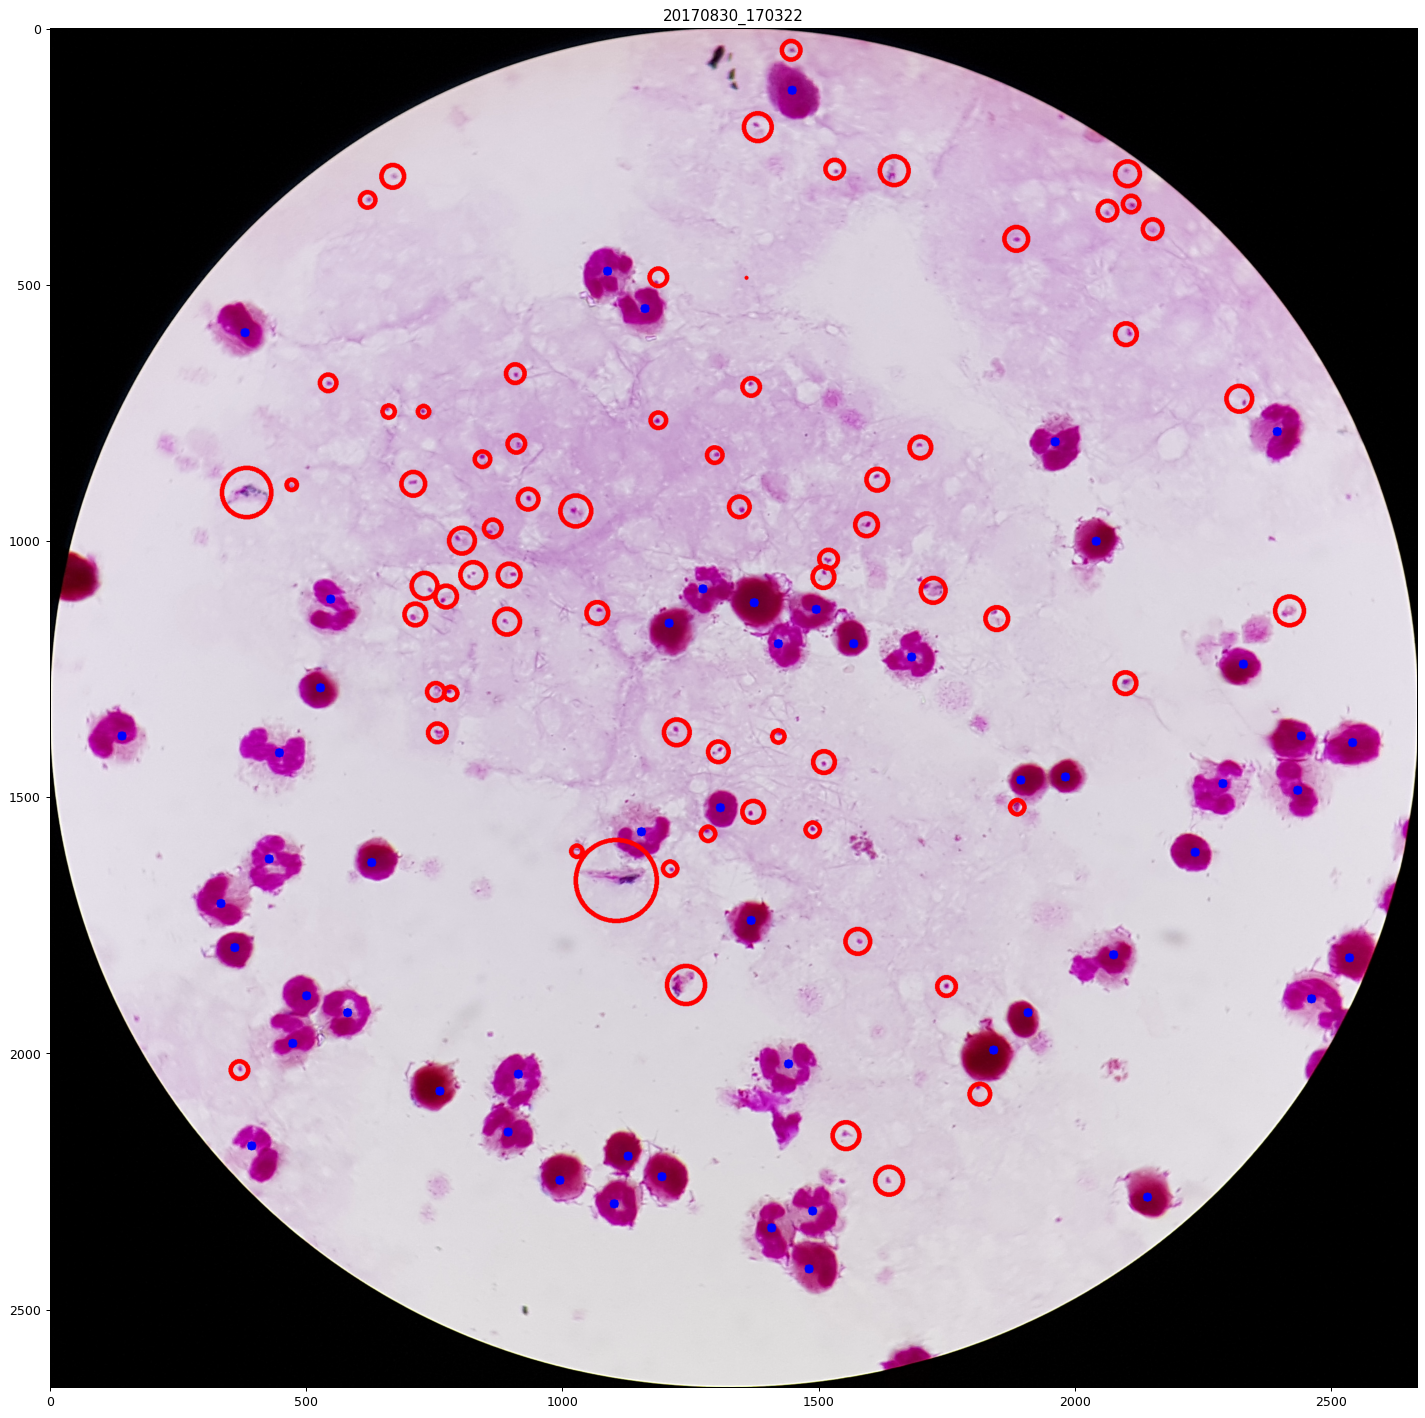

In [246]:
df_file = df[df['filename'] == filename]
img = cv2.imread(df_file['img_path_fit2circle'].iloc[-1], flags=cv2.IMREAD_IGNORE_ORIENTATION|cv2.IMREAD_COLOR)
fig = plt.figure(1, figsize=(20,20), dpi=90)
df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['adjusted_position'], row), axis = 1)
plt.imshow(img)

In [62]:
df['adjusted_bbx'] = df.apply(lambda row: get_bbx(row['adjusted_position'], row['annotation_type'], 150), axis = 1)

In [63]:
#filename =  'IMG_20150623_134547' 
df_file = df[df['filename'] == filename]
df_file.head()

Img no - Cell no      cell     comment annotation_type Number of points  \
0              3-1  Parasite  No_Comment          Circle                2   
1             3-10  Parasite  No_Comment          Circle                2   
2             3-11  Parasite  No_Comment          Circle                2   
3             3-12  Parasite  No_Comment          Circle                2   
4             3-13  Parasite  No_Comment          Circle                2   

                     position         filename  \
0  [(2931, 656), (2931, 675)]  20170820_152301   
1  [(2142, 721), (2146, 744)]  20170820_152301   
2  [(1975, 636), (1975, 660)]  20170820_152301   
3  [(1826, 557), (1822, 579)]  20170820_152301   
4  [(1792, 613), (1792, 637)]  20170820_152301   

                                            txt_path  \
0  ../data/Thick_Smears_150/GT_updated/TF87_15105...   
1  ../data/Thick_Smears_150/GT_updated/TF87_15105...   
2  ../data/Thick_Smears_150/GT_updated/TF87_15105...   
3  ../data/Thick_Smears_150/GT_updated/TF87_15105...   
4  ../data/Thick_Smears_150/GT_updated/TF87_15105...   

                                            img_path                     bbx  \
0  ../data/Thick_Smears_150/TF87_15105A/20170820_...  [2921, 646, 2940, 665]   
1  ../data/Thick_Smears_150/TF87_15105A/20170820_...  [2130, 709, 2153, 732]   
2  ../data/Thick_Smears_150/TF87_15105A/20170820_...  [1963, 624, 1987, 648]   
3  ../data/Thick_Smears_150/TF87_15105A/20170820_...  [1815, 546, 1837, 568]   
4  ../data/Thick_Smears_150/TF87_15105A/20170820_...  [1780, 601, 1804, 625]   

   patient_n_path           adjusted_position  \
0             440  [(2306, 473), (2306, 492)]   
1             440  [(1517, 538), (1521, 561)]   
2             440  [(1350, 453), (1350, 477)]   
3             440  [(1201, 374), (1197, 396)]   
4             440  [(1167, 430), (1167, 454)]   

                                 img_path_fit2circle            adjusted_bbx  
0  ../data/Thick_Smears_150/fit_to_circle/cropped...  [2296, 463, 2315, 482]  
1  ../data/Thick_Smears_150/fit_to_circle/cropped...  [1505, 526, 1528, 549]  
2  ../data/Thick_Smears_150/fit_to_circle/cropped...  [1338, 441, 1362, 465]  
3  ../data/Thick_Smears_150/fit_to_circle/cropped...  [1190, 363, 1212, 385]  
4  ../data/Thick_Smears_150/fit_to_circle/cropped...  [1155, 418, 1179, 442]

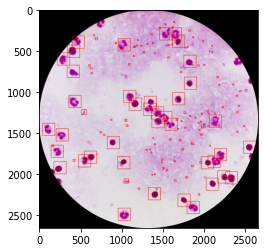

In [143]:
img = cv2.imread(df_file['img_path_fit2circle'].iloc[-1], cv2.IMREAD_COLOR)
img_with_box = bbv.draw_multiple_rectangles(img, df_file['adjusted_bbx'].tolist(), bbox_color = (255, 0, 0), thickness=3)
plt.imshow(img_with_box)

## Crop tiles

In [276]:
def plot_tiles(img, tile_w, tile_h):
    img_shape = img.shape
    tile_size = (tile_w, tile_h)
    offset = (tile_w, tile_h)

    for x in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
        #print(i)
        for y in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
            #print(j)
            #print((offset[1]*i, min(offset[1]*i+tile_size[1], img_shape[0])), (offset[0]*j, min(offset[0]*j+tile_size[0], img_shape[1])))
            x_min = min(offset[1] * x + tile_size[1], img_shape[0])
            x_max = offset[1] * x
            y_min = min(offset[0] * y + tile_size[0], img_shape[1])
            y_max = offset[0]*y
            cv2.rectangle(img, (x_max, x_min), (y_max, y_min), (0, 0, 255), 3)
            #cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
            # Debugging the tiles
            #cv2.imwrite("debug_" + str(i) + "_" + str(j) + ".png", cropped_img)
    plt.imshow(crop_img)

def crop_tiles(img, tile_w, tile_h):
    img_shape = img.shape
    tile_size = (tile_w, tile_h)
    offset = (tile_w, tile_h)
    for x in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
        for y in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
            x_min = offset[1] * x
            x_max = min(offset[1] * x + tile_size[1], img_shape[0])
            y_min = offset[0]*y
            y_max = min(offset[0] * y + tile_size[0], img_shape[1])
            crop_image = img[x_min : x_min + tile_w, y_min: y_min + tile_h]
            cv2.imwrite(path_cropped + f'/cropped/{x_min}_{x_max}_{y_min}_{y_max}.png', crop_image) 
    #plt.imshow(crop_image)


In [277]:
crop_tiles(img_cropped, 256, 256)

In [278]:
def convert_labels(path, x1, y1, x2, y2):
    """
    Definition: Parses label files to extract label and bounding box
        coordinates.  Converts (x1, y1, x1, y2) KITTI format to
        (x, y, width, height) normalized YOLO format.
    """
    def sorting(l1, l2):
        if l1 > l2:
            lmax, lmin = l1, l2
            return lmax, lmin
        else:
            lmax, lmin = l2, l1
            return lmax, lmin
    size = get_img_shape(path)
    xmax, xmin = sorting(x1, x2)
    ymax, ymin = sorting(y1, y2)
    dw = 1./size[1]
    dh = 1./size[0]
    x = (xmin + xmax)/2.0
    y = (ymin + ymax)/2.0
    w = xmax - xmin
    h = ymax - ymin
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

In [279]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list
        order: [x1, y1, x2, y2] 
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : list
        order: [x1, y1, x2, y2]
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [280]:
def get_intersection_percent(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list
        order: [x1, y1, x2, y2] 
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : list
        order: [x1, y1, x2, y2]
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    print('bb1: ', bb1)
    print('bb2: ', bb2)

    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area)
    print(iou)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [282]:
###############################################################################
def slice_img(input_im, input_mask, 
                     filename,
                    outdir_im, 
                     outdir_mask,
                     outdir_label,
                      classes_dic, 
                     category, 
                     box_coords, resize_factor = 1,
                  sliceHeight=256, sliceWidth=256,
                  zero_frac_thresh=0, overlap=0, pad=0, verbose = False,
                  box_coords_dir='', yolt_coords_dir='', create_mask = False):
    '''
    ADAPTED FROM YOLT/SCRIPTS/SLICE_IM.PY
    Assume input_im is rgb
    Slice large image into smaller pieces,
    ignore slices with a percentage null greater then zero_fract_thresh'''
    
    if verbose == True:
        print('############# slice_img #############')
    print('box_coords: ', box_coords)
    img = cv2.imread(input_im, flags=cv2.IMREAD_IGNORE_ORIENTATION|cv2.IMREAD_COLOR)  # color
    if create_mask:
        mask = cv2.imread(input_mask, flags=cv2.IMREAD_IGNORE_ORIENTATION|cv2.IMREAD_BW)
    category_num = [classes_dic[k] for k in category] 

    resized_img = cv2.resize(img, (int(round(img.shape[1] * resize_factor)), int(round(img.shape[0] * resize_factor))))
    if create_mask == True:
        resized_mask = cv2.resize(mask, (int(round(mask.shape[1] * resize_factor)), int(round(mask.shape[0] * resize_factor))))
    resized_box_coords = np.array(np.round(np.array(box_coords) * np.array(resize_factor)).astype(int))


    im_h, im_w = resized_img.shape[:2]
    if verbose:
        print('im_h', im_h)
        print('im_w', im_w)

    win_size = sliceHeight*sliceWidth

    # if slice sizes are large than image, pad the edges
    if sliceHeight > im_h:
        pad = sliceHeight - im_h
    if sliceWidth > im_w:
        pad = max(pad, sliceWidth - im_w)
    # pad the edge of the image with black pixels
    if pad > 0:
        border_color = (0, 0, 0)
        resized_img = cv2.copyMakeBorder(resized_img, pad, pad, pad, pad,
                                   cv2.BORDER_CONSTANT, value=border_color)
        if create_mask == True:
            resized_mask = cv2.copyMakeBorder(resized_img, pad, pad, pad, pad,
                                cv2.BORDER_CONSTANT, value=border_color)

    t0 = time.time()
    n_ims = 0
    n_ims_nonull = 0
    dx = int((1. - overlap) * sliceWidth)
    dy = int((1. - overlap) * sliceHeight)
    if verbose:
        print('dx', dx)
        print('dy', dy)
    dict_yolo = {}
    dict_bbx = {}
    max_annot = 0

    for y in range(0, im_h, dy):  # sliceHeight:
        for x in range(0, im_w, dx):  # sliceWidth:
            n_ims += 1
            # extract image
            # make sure we don't go past the edge of the image
            if y + sliceHeight > im_h:
                y0 = im_h - sliceHeight
            else:
                y0 = y
            if x + sliceWidth > im_w:
                x0 = im_w - sliceWidth
            else:
                x0 = x

            window_c = resized_img[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            if create_mask == True:
                window_mask = resized_mask[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
##           gt_c = gt_image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
#             gt_c = image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            win_h, win_w = window_c.shape[:2]
    
            outname_part = 'slice_' + filename + \
            '_' + str(y0) + '_' + str(x0) + \
            '_' + str(win_h) + '_' + str(win_w) + \
            '_' + str(pad)

            if create_mask == True:
                outname_mask_part = 'slice_mask_' + filename + \
                    '_' + str(y0) + '_' + str(x0) + \
                    '_' + str(win_h) + '_' + str(win_w) + \
                    '_' + str(pad)
        

            # get black and white image
            window = cv2.cvtColor(window_c, cv2.COLOR_BGR2GRAY)

            # find threshold of image that's not black
            # https://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html?highlight=threshold
            ret, thresh1 = cv2.threshold(window, 2, 255, cv2.THRESH_BINARY)
            non_zero_counts = cv2.countNonZero(thresh1)
            zero_counts = win_size - non_zero_counts
            zero_frac = float(zero_counts) / win_size
            # skip if image is mostly empty
            if zero_frac >= zero_frac_thresh:
                if verbose:
                    print("Zero frac too high at:", zero_frac)
                continue
                
            new_box_coords = []
            yolt_coords = []
            annot_count = 0

            for box, cat in zip(resized_box_coords, category_num):
                cut_box = 0
                percent_in_cut_img = get_intersection_percent(box, [x0, y0, x0 + sliceWidth, y0 + sliceHeight])

                if percent_in_cut_img > 0.75:   
                    resized_box_cat = np.asarray([box[0] - x0, box[1] - y0, box[2] - x0, box[3] - y0, cat])
                    new_box_coords.append(resized_box_cat)
                    annot_count += 1
                    # Input to convert: image size: (w,h), box: [x0, x1, y0, y1]
                    #print(box)
                    yolt_co_i = convert((win_w, win_h), box)
                    yolt_coords.append(yolt_co_i)

                    
            if annot_count > max_annot:
                max_annot = annot_count

            #  save
            outname_im = os.path.join(outdir_im, outname_part + '.png')
            if create_mask == True:
                outname_mask = os.path.join(outdir_mask, outname_mask_part + '.png')
            txt_outpath = os.path.join(outdir_label, outname_part + '.txt')

            dict_yolo[outname_im] = yolt_coords
            dict_bbx[outname_im] = new_box_coords
          

            # save yolt ims
            if verbose:
                print("image output:", outname_im)
            cv2.imwrite(outname_im, window_c)
            if create_mask == True:
                cv2.imwrite(outname_mask, window_mask)

            # save yolt labels
            txt_outfile = open(txt_outpath, "w+")
            if verbose:
                print("txt output:" + txt_outpath)
            for bb in yolt_coords:
                outstring = str(category_num) + " " + \
                    " ".join([str(a) for a in bb]) + '\n'
                if verbose:
                    print("outstring:", outstring)
                txt_outfile.write(outstring)
            txt_outfile.close()

            # if desired, save coords files
            # save box coords dictionary so that yolt_eval.py can read it
            if len(box_coords_dir) > 0:
                coords_dic = gt_dic_from_box_coords(box_coords)
                outname_pkl = os.path.join(
                    box_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(coords_dic, open(outname_pkl, 'wb'), protocol=2)
            if len(yolt_coords_dir) > 0:
                outname_pkl = os.path.join(
                    yolt_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(yolt_coords, open(outname_pkl, 'wb'), protocol=2)

            n_ims_nonull += 1

    if verbose:
        print("Num slices:", n_ims, "Num non-null slices:", n_ims_nonull,
              "sliceHeight", sliceHeight, "sliceWidth", sliceWidth)
        print("Time to slice", input_im, time.time()-t0, "seconds")

    return dict_yolo, dict_bbx, max_annot

def convert(size, box):
    '''Input = image size: (w,h), box: [x0, x1, y0, y1]'''
    dw = 1./size[0]
    dh = 1./size[1]
    xmid = (box[0] + box[1])/2.0
    ymid = (box[2] + box[3])/2.0
    w0 = box[1] - box[0]
    h0 = box[3] - box[2]
    x = xmid*dw
    y = ymid*dh
    w = w0*dw
    h = h0*dh
    return (x, y, w, h)

In [283]:
def cut_images(df,
                slice_height = 256,
                slice_width = 256,
                resize_factor = 1,
                classes_dic = {'Uninfected': 0, 'Parasitized': 1, 'Parasite': 1, 'White_Blood_Cell': 2},
                zero_frac_thresh = 0.9, 
                overlap = 0, 
                pad = 0,
                verbose=False):
    
    
    dict_mask = {}
    dict_bbxs = {}
    total_max_annot = 0
    mask_path = ''
    outdir_mask = ''

    for filename in df['filename'].unique():
        print('filename: ', filename, ', len dict_bbx: ', len(dict_bbxs))
        create_mask = False
        if df.loc[(df['filename'] == filename),'annotation_type'].iloc[-1] ==  'Polygon':
            # first we create a black and white mask where the polygons are white
            mask_path = poly2mask(filename)
            dict_mask[filename] = mask_path
            # now lets slice the images (and bbx although we will proabaly not use them)
            filename = df.loc[(df['filename'] == filename),'filename'].iloc[-1]
            img_path = df.loc[(df['filename'] == filename),'img_path'].iloc[-1]

            if not os.path.isdir(path_cropped):
                os.makedirs(path_cropped)

            outdir_im = path_cropped + f'/{filename}/img'
            outdir_mask = path_cropped + f'/{filename}/mask'
            outdir_label = path_cropped + f'/{filename}/labels'
            check_if_outdir_im = os.path.isdir(outdir_im)
            check_if_outdir_mask = os.path.isdir(outdir_mask)
            check_if_outdir_label = os.path.isdir(outdir_label)

            if not check_if_outdir_im:
                os.makedirs(outdir_im)
            if not check_if_outdir_mask:
                os.makedirs(outdir_mask)
            if not check_if_outdir_label:
                os.makedirs(outdir_label)
            create_mask = True

        else: 
            # now lets slice the images (and bbx although we will proabaly not use them)
            filename = df.loc[(df['filename'] == filename),'filename'].iloc[-1]
            img_path = df.loc[(df['filename'] == filename),'img_path'].iloc[-1]

            if not os.path.isdir(path_cropped):
                os.makedirs(path_cropped)

            outdir_im = path_cropped + f'/{filename}/img'
            outdir_label = path_cropped + f'/{filename}/labels'
            check_if_outdir_im = os.path.isdir(outdir_im)
            check_if_outdir_label = os.path.isdir(outdir_label)

            if not check_if_outdir_im:
                os.makedirs(outdir_im)
            if not check_if_outdir_label:
                os.makedirs(outdir_label)


        box_coords = df.loc[(df['filename'] == filename),'bbx'].tolist()
        category = df.loc[(df['filename'] == filename),'cell'].tolist()

        dict_yolo, dict_bbx, \
            max_annot = slice_img(img_path, mask_path, 
                                filename,
                                outdir_im, 
                                outdir_mask, 
                                outdir_label,
                                classes_dic, 
                                category, 
                                box_coords, 
                            sliceHeight= slice_height, sliceWidth=slice_width,
                            resize_factor = resize_factor,
                            zero_frac_thresh = zero_frac_thresh, overlap = overlap, pad = pad, verbose=False,
                            box_coords_dir='', yolt_coords_dir='', create_mask = create_mask)

        if max_annot > total_max_annot:
            total_max_annot = max_annot
            
        dict_bbxs.update(dict_bbx)
            

    return dict_yolo, dict_bbxs, dict_mask, total_max_annot

In [284]:
df_file

Img no - Cell no              cell     comment annotation_type  \
0              11-1          Parasite  No_Comment          Circle   
1             11-10          Parasite  No_Comment          Circle   
2             11-11          Parasite  No_Comment          Circle   
3             11-12          Parasite  No_Comment          Circle   
4              11-2          Parasite  No_Comment          Circle   
5              11-3          Parasite  No_Comment          Circle   
6              11-4          Parasite  No_Comment          Circle   
7              11-5          Parasite  No_Comment          Circle   
8              11-6          Parasite  No_Comment          Circle   
9              11-7          Parasite  No_Comment          Circle   
10             11-8          Parasite  No_Comment          Circle   
11             11-9          Parasite  No_Comment          Circle   
12            11-13  White_Blood_Cell  No_Comment           Point   
13            11-14  White_Blood_Cell  No_Comment           Point   
14            11-15  White_Blood_Cell  No_Comment           Point   
15            11-16  White_Blood_Cell  No_Comment           Point   
16            11-17  White_Blood_Cell  No_Comment           Point   
17            11-18  White_Blood_Cell  No_Comment           Point   
18            11-19  White_Blood_Cell  No_Comment           Point   
19            11-20  White_Blood_Cell  No_Comment           Point   
20            11-21  White_Blood_Cell  No_Comment           Point   
21            11-22  White_Blood_Cell  No_Comment           Point   
22            11-23  White_Blood_Cell  No_Comment           Point   
23            11-24  White_Blood_Cell  No_Comment           Point   
24            11-25  White_Blood_Cell  No_Comment           Point   
25            11-26  White_Blood_Cell  No_Comment           Point   
26            11-27  White_Blood_Cell  No_Comment           Point   
27            11-28  White_Blood_Cell  No_Comment           Point   

   Number of points                                  position  \
0                 2  [(2042.15, 1040.55), (2065.65, 1056.15)]   
1                 2    [(2562.8, 2389.95), (2568.9, 2405.05)]   
2                 2    [(2341.6, 2336.4), (2344.65, 2348.55)]   
3                 2     [(1876.7, 1484.35), (1882.1, 1495.1)]   
4                 2    [(3235.65, 1349.45), (3240.3, 1363.5)]   
5                 2  [(2670.25, 1561.35), (2678.35, 1570.35)]   
6                 2    [(2142.25, 1484.2), (2153.05, 1500.4)]   
7                 2    [(1308.1, 1797.1), (1317.25, 1813.25)]   
8                 2     [(1596.0, 1978.9), (1602.1, 1995.05)]   
9                 2     [(1862.65, 1830.4), (1868.7, 1846.6)]   
10                2   [(2580.95, 2230.4), (2587.05, 2254.55)]   
11                2      [(2578.0, 2520.3), (2578.0, 2533.4)]   
12                1                        [(2800.75, 601.7)]   
13                1                       [(3120.85, 992.95)]   
14                1                        [(2578.5, 1876.1)]   
15                1                       [(3254.25, 2068.8)]   
16                1                        [(2658.5, 2462.9)]   
17                1                       [(2258.4, 2445.15)]   
18                1                        [(2125.0, 1650.9)]   
19                1                        [(1938.3, 1982.8)]   
20                1                       [(1573.75, 2605.2)]   
21                1                      [(1449.25, 2222.85)]   
22                1                       [(1796.05, 1013.6)]   
23                1                         [(1707.1, 933.6)]   
24                1                        [(1591.55, 951.4)]   
25                1                       [(1502.6, 1188.55)]   
26                1                      [(1280.35, 1588.45)]   
27                1                         [(995.8, 1938.3)]   

           filename                                           txt_path  \
0   20170725_214324  ../data/Thick_Smears

In [293]:
df_para = df.loc[(df['cell'] == 'Parasite')].reset_index(drop=True)
shitty_ones = []

for index, row in df_para.iterrows():
    if row.position[0] == row.position[1]:
        shitty_ones.append(index)
        print(index)

11091
15329
19940
29561
30497
30848
34008
34632
46047
46123
47730
55899
58376
60196
61929
62116
62712
62744
66272
66329
67136
73473
74143
84909


In [295]:
df_para.columns[0:7]

Index(['Img no - Cell no', 'cell', 'comment', 'annotation_type',
       'Number of points', 'position', 'filename'],
      dtype='object')

In [297]:
df_para.iloc[shitty_ones][df_para.columns[0:7]]

Img no - Cell no      cell     comment annotation_type Number of points  \
11091             3-11  Parasite  No_Comment          Circle                2   
15329            0-156  Parasite  No_Comment          Circle                2   
19940             1-87  Parasite  No_Comment          Circle                2   
29561            11-37  Parasite  No_Comment          Circle                2   
30497            6-124  Parasite  No_Comment          Circle                2   
30848            5-162  Parasite  No_Comment          Circle                2   
34008            10-54  Parasite  No_Comment          Circle                2   
34632            4-160  Parasite  No_Comment          Circle                2   
46047              5-1  Parasite  No_Comment          Circle                2   
46123            10-13  Parasite  No_Comment          Circle                2   
47730             9-13  Parasite  No_Comment          Circle                2   
55899           10-107  Parasite  No_Comment          Circle                2   
58376            9-145  Parasite  No_Comment          Circle                2   
60196             1-35  Parasite  No_Comment          Circle                2   
61929             19-1  Parasite  No_Comment          Circle                2   
62116             20-1  Parasite  No_Comment          Circle                2   
62712             0-50  Parasite  No_Comment          Circle                2   
62744             0-94  Parasite  No_Comment          Circle                2   
66272            11-31  Parasite  No_Comment          Circle                2   
66329            11-85  Parasite  No_Comment          Circle                2   
67136             9-32  Parasite  No_Comment          Circle                2   
73473             4-47  Parasite  No_Comment          Circle                2   
74143              9-7  Parasite  No_Comment          Circle                2   
84909             2-11  Parasite  No_Comment          Circle                2   

                                       position         filename  
11091        [(2002.6, 768.3), (2002.6, 768.3)]  20170830_170322  
15329  [(2619.35, 1720.45), (2619.35, 1720.45)]  20170813_102928  
19940    [(1313.95, 1845.0), (1313.95, 1845.0)]  20170728_165143  
29561      [(1735.9, 2409.1), (1735.9, 2409.1)]  20170807_154024  
30497    [(2452.25, 2192.4), (2452.25, 2192.4)]  20170829_201518  
30848      [(1897.9, 2875.7), (1897.9, 2875.7)]  20170829_201349  
34008      [(2424.9, 961.05), (2424.9, 961.05)]  20170831_104551  
34632      [(1744.7, 2803.7), (1744.7, 2803.7)]  20170831_103804  
46047    [(2237.35, 998.25), (2237.35, 998.25)]  20170831_202541  
46123      [(856.8, 1609.95), (856.8, 1609.95)]  20170831_203023  
47730  [(2033.35, 1504.05), (2033.35, 1504.05)]  20170831_141322  
55899    [(3194.7, 1954.95), (3194.7, 1954.95)]  20170811_170123  
58376    [(1230.4, 1527.75), (1230.4, 1527.75)]  20170724_145845  
60196  [(3194.95, 1205.05), (3194.95, 1205.05)]  20170724_144325  
61929      [(3397.0, 818.75), (3397.0, 818.75)]  20170714_172841  
62116      [(3397.0, 818.75), (3397.0, 818.75)]  20170714_173105  
62712      [(2342.15, 497.3), (2342.15, 497.3)]  20170714_170133  
62744      [(3025.6, 1931.0), (3025.6, 1931.0)]  20170714_170133  
66272    [(3331.85, 1655.9), (3331.85, 1655.9)]  20170623_123114  
66329    [(1031.6, 1446.15), (1031.6, 1446.15)]  20170623_123114  
67136      [(1957.4, 1142.6), (1957.4, 1142.6)]  20170623_122022  
73473  [(2164.75, 2117.15), (2164.75, 2117.15)]  20171023_132712  
74143      [(2407.2, 2646.6), (2407.2, 2646.6)]  20170901_001029  
84909    [(1424.7, 2380.75), (1424.7, 2380.75)]  20170829_203106

In [242]:
#dict_yolo, dict_bbxs, dict_mask, total_max_annot = cut_images(df_para, classes_dic = {'Parasitized': 1})
dict_yolo, dict_bbxs, dict_mask, total_max_annot = cut_images(df)

filename:  20170830_170322 , len dict_bbx:  0
box_coords:  [[2733, 553, 2757, 577], [2010, 460, 2037, 487], [2002, 768, 2002, 768], [2080, 315, 2098, 333], [1255, 608, 1270, 623], [1301, 559, 1323, 581], [1542, 946, 1560, 964], [1821, 758, 1838, 775], [2002, 972, 2019, 989], [1822, 1038, 1837, 1053], [2744, 616, 2760, 632], [1932, 1106, 1947, 1121], [1978, 1205, 1998, 1225], [1544, 1083, 1561, 1100], [1479, 1114, 1494, 1129], [1366, 1023, 1377, 1034], [1298, 1023, 1310, 1035], [1178, 965, 1194, 981], [1340, 1158, 1363, 1181], [1110, 1167, 1120, 1177], [1003, 1163, 1051, 1211], [2784, 663, 2803, 682], [1566, 1190, 1586, 1210], [1654, 1208, 1684, 1238], [1498, 1248, 1515, 1265], [1434, 1268, 1459, 1293], [1456, 1335, 1481, 1360], [1528, 1337, 1550, 1359], [1522, 1426, 1547, 1451], [1405, 1379, 1426, 1400], [1361, 1356, 1386, 1381], [1345, 1414, 1366, 1435], [2696, 627, 2715, 646], [1700, 1411, 1721, 1432], [1418, 1572, 1431, 1585], [1387, 1567, 1404, 1584], [1390, 1647, 1408, 1665], [185

AssertionError: 

In [ ]:
len(dict_bbxs.keys())

In [ ]:
# same as above however this time checking for image slice with most parasites

imgs_name = keys = np.array(list(dict_bbxs.keys()))
true_boxes = np.zeros((imgs_name.shape[0], total_max_annot, 5))
print('imgs_name.shape: ', imgs_name.shape)
print('max_annot: ', total_max_annot)
print('true_boxes shape: ', true_boxes.shape)

max_parasitized = {}
            
for key, boxes in dict_bbxs.items():
    count_para = 0
    boxes = np.asarray(boxes)
    idx = int(np.where(imgs_name == key)[0])
    print('boxes shape: ', boxes.shape)
    print('key: ', key)
    print('index in list: ', idx)

    if len(boxes) != 0:
        for box in boxes:
            if box[4] == 1:
                count_para += 1
    max_parasitized[idx] = count_para
    
    if len(boxes) == 0:
        boxes = np.asarray([[0,0,0,0,0]])
    true_boxes[idx, :boxes.shape[0], :5] = boxes

In [ ]:
max(max_parasitized.items(), key=operator.itemgetter(1))[0]

In [ ]:
imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]]

In [ ]:
dict_bbxs[imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]]]

In [ ]:
img = cv2.imread(imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]], flags=cv2.IMREAD_IGNORE_ORIENTATION|cv2.IMREAD_COLOR)
list_bbxs = dict_bbxs[imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]]]
img_with_box = bbv.draw_multiple_rectangles(img, [box.tolist()[:4] for box in list_bbxs], bbox_color = (255, 0, 0), thickness=1)
plt.imshow(img_with_box)

In [79]:
with open(path_cropped + '/pickled/imgs_name.pkl', 'wb') as handle:
    pickle.dump(imgs_name, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(path_cropped + '/pickled/true_boxes.pkl', 'wb') as handle:
    pickle.dump(true_boxes, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(path_cropped + '/pickled/dict_bbxs.pkl', 'wb') as handle:
    pickle.dump(dict_bbxs, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(path_cropped + '/pickled/labels.pkl', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)    

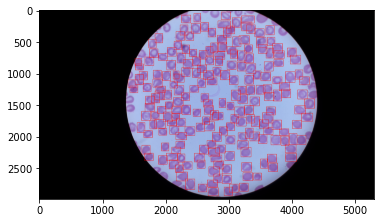

In [83]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
img_with_box = bbv.draw_multiple_rectangles(img, df_file['bbx'].tolist(), bbox_color = (255, 0, 0), thickness=3)
plt.imshow(img_with_box)

# Convert to YOLO format

In [84]:
with open('../data/pickled/true_boxes.pkl', 'rb') as handle:
    true_boxes = pickle.load(handle)
with open('../data/pickled/dict_bbxs.pkl', 'rb') as handle:
    dict_bbxs = pickle.load(handle)
with open('../data/pickled/labels.pkl', 'rb') as handle:
    df = pickle.load(handle)    

### Test train split patient level

In [85]:
df.reset_index(drop=True, inplace = True)
df

Patient no - Cell no        cell     comment annotation_type  \
0                       3-1  Uninfected  No_comment         Polygon   
1                       3-2  Uninfected  No_comment         Polygon   
2                       3-3  Uninfected  No_comment         Polygon   
3                       3-4  Uninfected  No_comment         Polygon   
4                       3-5  Uninfected  No_comment         Polygon   
...                     ...         ...         ...             ...   
196929                5-200  Uninfected  No_Comment           Point   
196930                5-201  Uninfected  No_Comment           Point   
196931                5-202  Uninfected  No_Comment           Point   
196932                5-203  Uninfected  No_Comment           Point   
196933                5-204  Uninfected  No_Comment           Point   

       Number of points                                           position  \
0                    14  [(2934, 38), (2955, 33), (2992, 35), (3015, 44...   
1                    15  [(3013, 141), (2993, 144), (2972, 157), (2956,...   
2                    14  [(2730, 135), (2704, 144), (2672, 165), (2661,...   
3                    14  [(2379, 137), (2353, 149), (2334, 169), (2332,...   
4                    14  [(2575, 140), (2548, 145), (2522, 161), (2500,...   
...                 ...                                                ...   
196929                1                                      [(2080, 643)]   
196930                1                                      [(1790, 606)]   
196931                1                                      [(1757, 756)]   
196932                1                                      [(1860, 856)]   
196933                1                                      [(1623, 683)]   

                   filename  \
0       IMG_20150817_103139   
1       IMG_20150817_103139   
2       IMG_20150817_103139   
3       IMG_20150817_103139   
4       IMG_20150817_103139   
...                     ...   
196929  IMG_20151115_181859   
196930  IMG_20151115_181859   
196931  IMG_20151115_181859   
196932  IMG_20151115_181859   
196933  IMG_20151115_181859   

                                                 txt_path  \
0       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
...                                                   ...   
196929  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196930  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196931  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196932  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196933  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                                                 img_path  \
0       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
...                                                   ...   
196929  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196930  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196931  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196932  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196933  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                           bbx  patient_n_path  \
0        [2905, 33, 3033, 131]              40   
1       [2951, 141, 3071, 272]              40   
2       [2658, 135, 2801, 276]              40   
3       [2332, 137, 2454, 265]              40   
4       [2499, 140, 2631, 272]              40   
...                        ...             ...   
196929  [2010, 573, 2150, 71

In [86]:
np.random.seed(2)
train_index = []
for patient_n in df['patient_n_path'].unique():
    df_patient = df.loc[df['patient_n_path'] == patient_n]
    mask = np.random.rand(len(df_patient)) < 0.8
    train_index.extend(df_patient[mask].index)
    print('patient: ', patient_n, ' length train_index: ', len(train_index), len(np.unique(train_index)))

patient:  40  length train_index:  618 618
patient:  13  length train_index:  1348 1348
patient:  89  length train_index:  2028 2028
patient:  201  length train_index:  3072 3072
patient:  202  length train_index:  3964 3964
patient:  47  length train_index:  4954 4954
patient:  148  length train_index:  5586 5586
patient:  16  length train_index:  6302 6302
patient:  87  length train_index:  6839 6839
patient:  203  length train_index:  7857 7857
patient:  121  length train_index:  8452 8452
patient:  50  length train_index:  9314 9314
patient:  138  length train_index:  10129 10129
patient:  60  length train_index:  10806 10806
patient:  204  length train_index:  11856 11856
patient:  3  length train_index:  12663 12663
patient:  10  length train_index:  13575 13575
patient:  205  length train_index:  14702 14702
patient:  206  length train_index:  15909 15909
patient:  83  length train_index:  16562 16562
patient:  207  length train_index:  17634 17634
patient:  95  length train_ind

patient:  84  length train_index:  145993 145993
patient:  91  length train_index:  146622 146622
patient:  57  length train_index:  147496 147496
patient:  85  length train_index:  148193 148193
patient:  109  length train_index:  149157 149157
patient:  107  length train_index:  150083 150083
patient:  23  length train_index:  150890 150890
patient:  117  length train_index:  152004 152004
patient:  244  length train_index:  153001 153001
patient:  61  length train_index:  153713 153713
patient:  43  length train_index:  154612 154612
patient:  128  length train_index:  155597 155597
patient:  11  length train_index:  156335 156335
patient:  17  length train_index:  156832 156832
patient:  119  length train_index:  157636 157636


In [87]:
df['train_test'] = 'test'
df.at[train_index, 'train_test'] = 'train'
df['train_test'].value_counts()

train    157636
test      39298
Name: train_test, dtype: int64

In [88]:
#sanity check
print('percentage train: ', len(df[df['train_test'] == 'train']) / len(df))

percentage train:  0.8004509124884479


In [89]:
#sanity check patient level
for patient_n in df['patient_n_path'].unique():
    df_patient = df.loc[df['patient_n_path'] == patient_n]
    percent_train = len(df_patient[df_patient['train_test'] == 'train']) / len(df_patient)
    print('patient: ', patient_n, ' percentage train: ', percent_train)

patient:  40  percentage train:  0.8015564202334631
patient:  13  percentage train:  0.7969432314410481
patient:  89  percentage train:  0.8095238095238095
patient:  201  percentage train:  0.7963386727688787
patient:  202  percentage train:  0.8221198156682028
patient:  47  percentage train:  0.7983870967741935
patient:  148  percentage train:  0.7959697732997482
patient:  16  percentage train:  0.798216276477146
patient:  87  percentage train:  0.7660485021398002
patient:  203  percentage train:  0.8085782366957903
patient:  121  percentage train:  0.7870370370370371
patient:  50  percentage train:  0.7959372114496768
patient:  138  percentage train:  0.8117529880478087
patient:  60  percentage train:  0.7974087161366313
patient:  204  percentage train:  0.8045977011494253
patient:  3  percentage train:  0.8037848605577689
patient:  10  percentage train:  0.792354474370113
patient:  205  percentage train:  0.7970297029702971
patient:  206  percentage train:  0.7940789473684211
patien

### Test train split patient & img_level

In [90]:
seed_n = 2
random.seed(seed_n)
train_index = []
for patient_n in df['patient_n_path'].unique():
    list_filenames = df.loc[df['patient_n_path'] == patient_n, 'filename'].unique().tolist()
    perct_total = round(len(list_filenames) * 0.8)
    list_filenames_masked = random.sample(list_filenames, perct_total)
    train_index.extend(df.loc[(df['patient_n_path'] == patient_n) & (df['filename'].isin(list_filenames_masked))].index)
    perc_train = len(df.loc[(df['patient_n_path'] == patient_n) & (df['filename'].isin(list_filenames_masked))]) / len(df.loc[(df['patient_n_path'] == patient_n)])
    print('patient: ', patient_n, ' percentage train cells: ', str(perc_train))

patient:  40  percentage train cells:  0.7600518806744487
patient:  13  percentage train cells:  0.8187772925764192
patient:  89  percentage train cells:  0.8023809523809524
patient:  201  percentage train cells:  0.7879481311975591
patient:  202  percentage train cells:  0.7963133640552995
patient:  47  percentage train cells:  0.8032258064516129
patient:  148  percentage train cells:  0.8312342569269522
patient:  16  percentage train cells:  0.7692307692307693
patient:  87  percentage train cells:  0.7617689015691869
patient:  203  percentage train cells:  0.8093725178713265
patient:  121  percentage train cells:  0.8029100529100529
patient:  50  percentage train cells:  0.7839335180055401
patient:  138  percentage train cells:  0.8067729083665338
patient:  60  percentage train cells:  0.7879858657243817
patient:  204  percentage train cells:  0.8022988505747126
patient:  3  percentage train cells:  0.8057768924302788
patient:  10  percentage train cells:  0.8297132927888793
patient:

patient:  238  percentage train cells:  0.8110355253212396
patient:  46  percentage train cells:  0.8009188361408882
patient:  35  percentage train cells:  0.8193891102257637
patient:  5  percentage train cells:  0.8043087971274686
patient:  102  percentage train cells:  0.8226059654631083
patient:  146  percentage train cells:  0.8119935170178282
patient:  129  percentage train cells:  0.8077777777777778
patient:  9  percentage train cells:  0.7528089887640449
patient:  137  percentage train cells:  0.8074277854195323
patient:  115  percentage train cells:  0.804945054945055
patient:  66  percentage train cells:  0.8169014084507042
patient:  42  percentage train cells:  0.7718780727630286
patient:  70  percentage train cells:  0.8104008667388949
patient:  36  percentage train cells:  0.816350710900474
patient:  105  percentage train cells:  0.7936404931862427
patient:  12  percentage train cells:  0.7365269461077845
patient:  120  percentage train cells:  0.8256130790190735
patient:  

In [91]:
df['train_test'] = 'test'
df.at[train_index, 'train_test'] = 'train'
df['train_test'].value_counts()

train    157849
test      39085
Name: train_test, dtype: int64

In [92]:
#sanity check
print('percentage train: ', len(df[df['train_test'] == 'train']) / len(df))

percentage train:  0.8015324931195222


In [93]:
#sanity check patient level
for patient_n in df['patient_n_path'].unique():
    df_patient = df.loc[df['patient_n_path'] == patient_n]
    percent_train = len(df_patient[df_patient['train_test'] == 'train']) / len(df_patient)
    print('patient: ', patient_n, ' percentage train: ', percent_train)

patient:  40  percentage train:  0.7600518806744487
patient:  13  percentage train:  0.8187772925764192
patient:  89  percentage train:  0.8023809523809524
patient:  201  percentage train:  0.7879481311975591
patient:  202  percentage train:  0.7963133640552995
patient:  47  percentage train:  0.8032258064516129
patient:  148  percentage train:  0.8312342569269522
patient:  16  percentage train:  0.7692307692307693
patient:  87  percentage train:  0.7617689015691869
patient:  203  percentage train:  0.8093725178713265
patient:  121  percentage train:  0.8029100529100529
patient:  50  percentage train:  0.7839335180055401
patient:  138  percentage train:  0.8067729083665338
patient:  60  percentage train:  0.7879858657243817
patient:  204  percentage train:  0.8022988505747126
patient:  3  percentage train:  0.8057768924302788
patient:  10  percentage train:  0.8297132927888793
patient:  205  percentage train:  0.804101838755304
patient:  206  percentage train:  0.8111842105263158
patie

In [94]:
df.head()

Patient no - Cell no        cell     comment annotation_type  \
0                  3-1  Uninfected  No_comment         Polygon   
1                  3-2  Uninfected  No_comment         Polygon   
2                  3-3  Uninfected  No_comment         Polygon   
3                  3-4  Uninfected  No_comment         Polygon   
4                  3-5  Uninfected  No_comment         Polygon   

  Number of points                                           position  \
0               14  [(2934, 38), (2955, 33), (2992, 35), (3015, 44...   
1               15  [(3013, 141), (2993, 144), (2972, 157), (2956,...   
2               14  [(2730, 135), (2704, 144), (2672, 165), (2661,...   
3               14  [(2379, 137), (2353, 149), (2334, 169), (2332,...   
4               14  [(2575, 140), (2548, 145), (2522, 161), (2500,...   

              filename                                           txt_path  \
0  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                                            img_path                     bbx  \
0  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   [2905, 33, 3033, 131]   
1  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2951, 141, 3071, 272]   
2  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2658, 135, 2801, 276]   
3  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2332, 137, 2454, 265]   
4  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2499, 140, 2631, 272]   

   patient_n_path                                  adjusted_position  \
0              40  [(1652, 29), (1673, 24), (1710, 26), (1733, 35...   
1              40  [(1731, 132), (1711, 135), (1690, 148), (1674,...   
2              40  [(1448, 126), (1422, 135), (1390, 156), (1379,...   
3              40  [(1097, 128), (1071, 140), (1052, 160), (1050,...   
4              40  [(1293, 131), (1266, 136), (1240, 152), (1218,...   

                                 img_path_fit2circle  \
0  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
1  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
2  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
3  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
4  ../data/fit_to_circle/cropped_P40_IMG_20150817...   

                                mask_path_fit2circle            adjusted_bbx  \
0  ../data/fit_to_circle/masks_cropped_P40_IMG_20...   [1623, 24, 1751, 122]   
1  ../data/fit_to_circle/masks_cropped_P40_IMG_20...  [1669, 132, 1789, 263]   
2  ../data/fit_to_circle/masks_cropped_P40_IMG_20...  [1376, 126, 1519, 267]   
3  ../data/fit_to_circle/masks_cropped_P40_IMG_20...  [1050, 128, 1172, 256]   
4  ../data/fit_to_circle/masks_cropped_P40_IMG_20...  [1217, 131, 1349, 263]   

                                    mask_path train_test  
0  ../data/masks/mask_IMG_20150817_103139.png      train  
1  ../data/masks/mask_IMG_20150817_103139.png      train  
2  ../data/masks/mask_IMG_20150817_103139.png      train  
3  ../data/masks/mask_IMG_20150817_103139.png      train  
4  ../data/masks/mask_IMG_20150817_103139.png      train

### Create test and train folders fit to circle

../data/fit_to_circle/cropped_P206_IMG_20151112_164625_masks.png


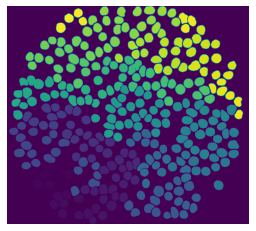

In [127]:
mask_path_fit2circle = df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path_fit2circle'] == '../data/fit_to_circle/cropped_P206_IMG_20151112_164625.png') , 'mask_path_fit2circle'][19612]
print(mask_path_fit2circle)
masks_f2c = plt.imread(mask_path_fit2circle, cv2.IMREAD_COLOR)
plt.imshow(masks_f2c)
plt.axis('off')
plt.show()

copy img to training:  IMG_20150817_103139
copy mask to training:  IMG_20150817_103139
copy img to training:  IMG_20150817_103303
copy mask to training:  IMG_20150817_103303
copy img to test:  IMG_20150817_102702
copy mask to test:  IMG_20150817_102702
../data/fit_to_circle/test/cropped_P40_IMG_20150817_102702_masks.png
<class 'numpy.ndarray'> (1024, 1024)


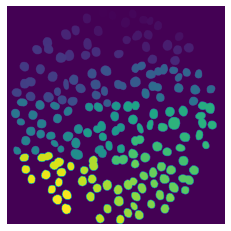

copy img to training:  IMG_20150817_102823
copy mask to training:  IMG_20150817_102823
copy img to training:  IMG_20150817_103901
copy mask to training:  IMG_20150817_103901
copy img to training:  IMG_20150725_123938
copy mask to training:  IMG_20150725_123938
copy img to training:  IMG_20150725_125213
copy mask to training:  IMG_20150725_125213
copy img to training:  IMG_20150725_125847
copy mask to training:  IMG_20150725_125847
copy img to test:  IMG_20150725_124606
copy mask to test:  IMG_20150725_124606
../data/fit_to_circle/test/cropped_P13_IMG_20150725_124606_masks.png
<class 'numpy.ndarray'> (1024, 1024)


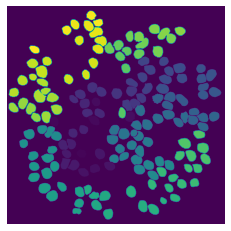

copy img to training:  IMG_20150725_124830
copy mask to training:  IMG_20150725_124830
copy img to training:  IMG_20151004_130810
copy mask to training:  IMG_20151004_130810
copy img to test:  IMG_20151004_130408
copy mask to test:  IMG_20151004_130408
../data/fit_to_circle/test/cropped_P89_IMG_20151004_130408_masks.png
<class 'numpy.ndarray'> (1024, 1024)


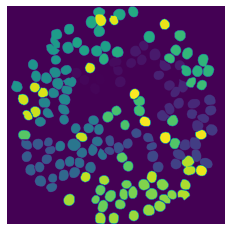

copy img to training:  IMG_20151004_130549
copy mask to training:  IMG_20151004_130549
copy img to training:  IMG_20151004_131030
copy mask to training:  IMG_20151004_131030
copy img to training:  IMG_20151004_131129
copy mask to training:  IMG_20151004_131129
copy img to test:  IMG_20151029_162934
copy mask to test:  IMG_20151029_162934
../data/fit_to_circle/test/cropped_P201_IMG_20151029_162934_masks.png
<class 'numpy.ndarray'> (1024, 1024)


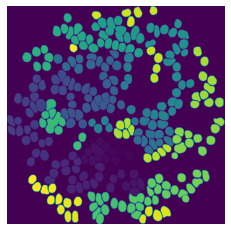

copy img to training:  IMG_20151029_162357
copy mask to training:  IMG_20151029_162357
copy img to training:  IMG_20151029_162605
copy mask to training:  IMG_20151029_162605
copy img to training:  IMG_20151029_162439
copy mask to training:  IMG_20151029_162439
copy img to training:  IMG_20151029_162834
copy mask to training:  IMG_20151029_162834
copy img to test:  IMG_20151112_153246
copy mask to test:  IMG_20151112_153246
../data/fit_to_circle/test/cropped_P202_IMG_20151112_153246_masks.png
<class 'numpy.ndarray'> (1024, 1024)


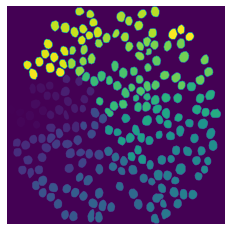

copy img to training:  IMG_20151112_153041
copy mask to training:  IMG_20151112_153041
copy img to training:  IMG_20151112_153106
copy mask to training:  IMG_20151112_153106
copy img to training:  IMG_20151112_153147
copy mask to training:  IMG_20151112_153147
copy img to training:  IMG_20151112_152234
copy mask to training:  IMG_20151112_152234
copy img to training:  IMG_20150820_124943
copy mask to training:  IMG_20150820_124943
copy img to training:  IMG_20150820_125057
copy mask to training:  IMG_20150820_125057
copy img to training:  IMG_20150820_124025
copy mask to training:  IMG_20150820_124025
copy img to test:  IMG_20150820_123717
copy mask to test:  IMG_20150820_123717
../data/fit_to_circle/test/cropped_P47_IMG_20150820_123717_masks.png
<class 'numpy.ndarray'> (1024, 1024)


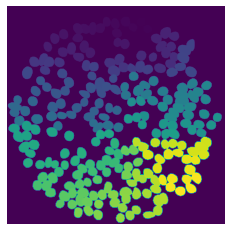

copy img to training:  IMG_20150820_124259
copy mask to training:  IMG_20150820_124259
copy img to training:  IMG_20151203_153036
copy mask to training:  IMG_20151203_153036
copy img to training:  IMG_20151203_153713
copy mask to training:  IMG_20151203_153713
copy img to training:  IMG_20151203_153410
copy mask to training:  IMG_20151203_153410
copy img to training:  IMG_20151203_152841
copy mask to training:  IMG_20151203_152841
copy img to test:  IMG_20151203_154111
copy mask to test:  IMG_20151203_154111
../data/fit_to_circle/test/cropped_P148_IMG_20151203_154111_masks.png
<class 'numpy.ndarray'> (1024, 1024)


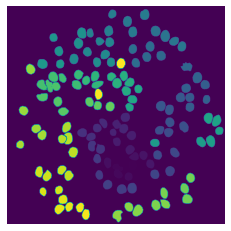

copy img to training:  IMG_20150728_123154
copy mask to training:  IMG_20150728_123154
copy img to training:  IMG_20150728_121151
copy mask to training:  IMG_20150728_121151
copy img to training:  IMG_20150728_121350
copy mask to training:  IMG_20150728_121350
copy img to test:  IMG_20150728_123237
copy mask to test:  IMG_20150728_123237
../data/fit_to_circle/test/cropped_P16_IMG_20150728_123237_masks.png
<class 'numpy.ndarray'> (1024, 1024)


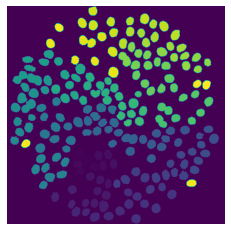

copy img to training:  IMG_20150728_123510
copy mask to training:  IMG_20150728_123510
copy img to training:  IMG_20151004_104623
copy mask to training:  IMG_20151004_104623
copy img to training:  IMG_20151004_104728
copy mask to training:  IMG_20151004_104728
copy img to test:  IMG_20151004_104408
copy mask to test:  IMG_20151004_104408
../data/fit_to_circle/test/cropped_P87_IMG_20151004_104408_masks.png
<class 'numpy.ndarray'> (1024, 1024)


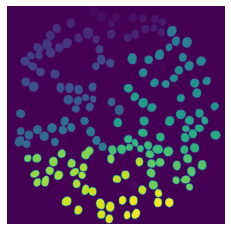

copy img to training:  IMG_20151004_104813
copy mask to training:  IMG_20151004_104813
copy img to training:  IMG_20151004_104441
copy mask to training:  IMG_20151004_104441
copy img to training:  IMG_20151106_135337
copy mask to training:  IMG_20151106_135337
copy img to training:  IMG_20151106_134931
copy mask to training:  IMG_20151106_134931
copy img to training:  IMG_20151106_135228
copy mask to training:  IMG_20151106_135228
copy img to training:  IMG_20151106_135653
copy mask to training:  IMG_20151106_135653
copy img to test:  IMG_20151106_134733
copy mask to test:  IMG_20151106_134733
../data/fit_to_circle/test/cropped_P203_IMG_20151106_134733_masks.png
<class 'numpy.ndarray'> (1024, 1024)


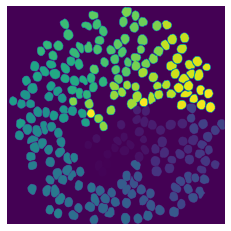

copy img to test:  IMG_20151116_093109
copy mask to test:  IMG_20151116_093109
../data/fit_to_circle/test/cropped_P121_IMG_20151116_093109_masks.png
<class 'numpy.ndarray'> (1024, 1024)


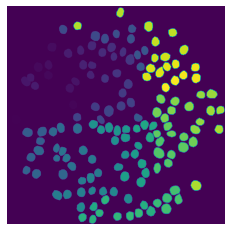

copy img to training:  IMG_20151116_092925
copy mask to training:  IMG_20151116_092925
copy img to training:  IMG_20151116_093748
copy mask to training:  IMG_20151116_093748
copy img to training:  IMG_20151116_093704
copy mask to training:  IMG_20151116_093704
copy img to training:  IMG_20151116_093629
copy mask to training:  IMG_20151116_093629
copy img to test:  IMG_20150820_162813
copy mask to test:  IMG_20150820_162813
../data/fit_to_circle/test/cropped_P50_IMG_20150820_162813_masks.png
<class 'numpy.ndarray'> (1024, 1024)


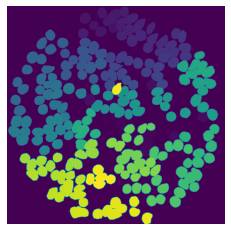

copy img to training:  IMG_20150820_162153
copy mask to training:  IMG_20150820_162153
copy img to training:  IMG_20150820_163347
copy mask to training:  IMG_20150820_163347
copy img to training:  IMG_20150820_162504
copy mask to training:  IMG_20150820_162504
copy img to training:  IMG_20150820_162300
copy mask to training:  IMG_20150820_162300
copy img to test:  IMG_20151201_142942
copy mask to test:  IMG_20151201_142942
../data/fit_to_circle/test/cropped_P138_IMG_20151201_142942_masks.png
<class 'numpy.ndarray'> (1024, 1024)


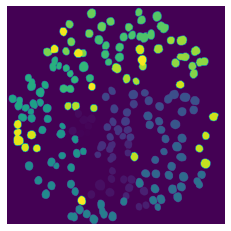

copy img to training:  IMG_20151201_143025
copy mask to training:  IMG_20151201_143025
copy img to training:  IMG_20151201_141604
copy mask to training:  IMG_20151201_141604
copy img to training:  IMG_20151201_142846
copy mask to training:  IMG_20151201_142846
copy img to training:  IMG_20151201_142514
copy mask to training:  IMG_20151201_142514
copy img to test:  IMG_20150918_141001
copy mask to test:  IMG_20150918_141001
../data/fit_to_circle/test/cropped_P60_IMG_20150918_141001_masks.png
<class 'numpy.ndarray'> (1024, 1024)


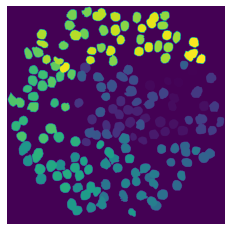

copy img to training:  IMG_20150918_141129
copy mask to training:  IMG_20150918_141129
copy img to training:  IMG_20150918_141351
copy mask to training:  IMG_20150918_141351
copy img to training:  IMG_20150918_140900
copy mask to training:  IMG_20150918_140900
copy img to training:  IMG_20150918_141314
copy mask to training:  IMG_20150918_141314
copy img to test:  IMG_20151106_112422
copy mask to test:  IMG_20151106_112422
../data/fit_to_circle/test/cropped_P204_IMG_20151106_112422_masks.png
<class 'numpy.ndarray'> (1024, 1024)


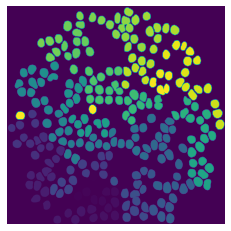

copy img to training:  IMG_20151106_112603
copy mask to training:  IMG_20151106_112603
copy img to training:  IMG_20151106_112853
copy mask to training:  IMG_20151106_112853
copy img to training:  IMG_20151106_112252
copy mask to training:  IMG_20151106_112252
copy img to training:  IMG_20151106_112759
copy mask to training:  IMG_20151106_112759
copy img to test:  IMG_20150621_112138
copy mask to test:  IMG_20150621_112138
../data/fit_to_circle/test/cropped_P3_IMG_20150621_112138_masks.png
<class 'numpy.ndarray'> (1024, 1024)


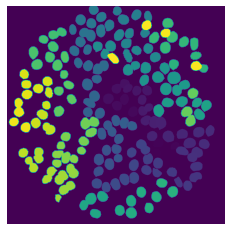

copy img to training:  IMG_20150621_112023
copy mask to training:  IMG_20150621_112023
copy img to training:  IMG_20150621_112043
copy mask to training:  IMG_20150621_112043
copy img to training:  IMG_20150621_112227
copy mask to training:  IMG_20150621_112227
copy img to training:  IMG_20150621_112116
copy mask to training:  IMG_20150621_112116
copy img to training:  IMG_20150724_102330
copy mask to training:  IMG_20150724_102330
copy img to training:  IMG_20150724_103233
copy mask to training:  IMG_20150724_103233
copy img to test:  IMG_20150724_102843
copy mask to test:  IMG_20150724_102843
../data/fit_to_circle/test/cropped_P10_IMG_20150724_102843_masks.png
<class 'numpy.ndarray'> (1024, 1024)


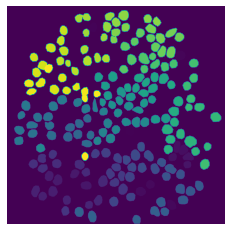

copy img to training:  IMG_20150724_102951
copy mask to training:  IMG_20150724_102951
copy img to training:  IMG_20150724_103054
copy mask to training:  IMG_20150724_103054
copy img to test:  IMG_20151106_110230
copy mask to test:  IMG_20151106_110230
../data/fit_to_circle/test/cropped_P205_IMG_20151106_110230_masks.png
<class 'numpy.ndarray'> (1024, 1024)


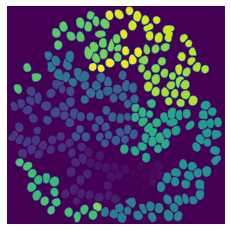

copy img to training:  IMG_20151106_105834
copy mask to training:  IMG_20151106_105834
copy img to training:  IMG_20151106_105437
copy mask to training:  IMG_20151106_105437
copy img to training:  IMG_20151106_110411
copy mask to training:  IMG_20151106_110411
copy img to training:  IMG_20151106_105941
copy mask to training:  IMG_20151106_105941
copy img to training:  IMG_20151112_164723
copy mask to training:  IMG_20151112_164723
copy img to training:  IMG_20151112_165055
copy mask to training:  IMG_20151112_165055
copy img to training:  IMG_20151112_164834
copy mask to training:  IMG_20151112_164834
copy img to training:  IMG_20151112_164625
copy mask to training:  IMG_20151112_164625
copy img to test:  IMG_20151112_164918
copy mask to test:  IMG_20151112_164918
../data/fit_to_circle/test/cropped_P206_IMG_20151112_164918_masks.png
<class 'numpy.ndarray'> (1024, 1024)


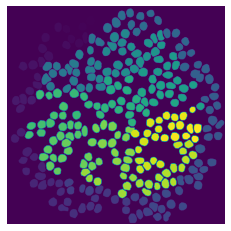

copy img to training:  IMG_20151002_144610
copy mask to training:  IMG_20151002_144610
copy img to test:  IMG_20151002_144341
copy mask to test:  IMG_20151002_144341
../data/fit_to_circle/test/cropped_P83_IMG_20151002_144341_masks.png
<class 'numpy.ndarray'> (1024, 1024)


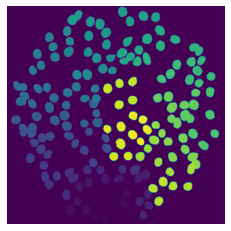

copy img to training:  IMG_20151002_144855
copy mask to training:  IMG_20151002_144855
copy img to training:  IMG_20151002_145014
copy mask to training:  IMG_20151002_145014
copy img to training:  IMG_20151002_145330
copy mask to training:  IMG_20151002_145330
copy img to training:  IMG_20151112_131255
copy mask to training:  IMG_20151112_131255
copy img to test:  IMG_20151112_131622
copy mask to test:  IMG_20151112_131622
../data/fit_to_circle/test/cropped_P207_IMG_20151112_131622_masks.png
<class 'numpy.ndarray'> (1024, 1024)


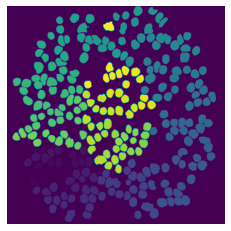

copy img to training:  IMG_20151112_131546
copy mask to training:  IMG_20151112_131546
copy img to training:  IMG_20151112_131408
copy mask to training:  IMG_20151112_131408
copy img to training:  IMG_20151112_131731
copy mask to training:  IMG_20151112_131731
copy img to training:  IMG_20151005_121656
copy mask to training:  IMG_20151005_121656
copy img to training:  IMG_20151005_121425
copy mask to training:  IMG_20151005_121425
copy img to test:  IMG_20151005_121554
copy mask to test:  IMG_20151005_121554
../data/fit_to_circle/test/cropped_P95_IMG_20151005_121554_masks.png
<class 'numpy.ndarray'> (1024, 1024)


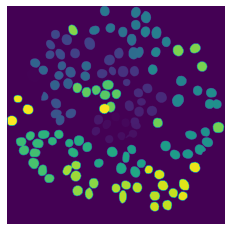

copy img to training:  IMG_20151005_121343
copy mask to training:  IMG_20151005_121343
copy img to training:  IMG_20151005_121048
copy mask to training:  IMG_20151005_121048
copy img to training:  IMG_20150819_133447
copy mask to training:  IMG_20150819_133447
copy img to training:  IMG_20150819_134326
copy mask to training:  IMG_20150819_134326
copy img to test:  IMG_20150819_133236
copy mask to test:  IMG_20150819_133236
../data/fit_to_circle/test/cropped_P29_IMG_20150819_133236_masks.png
<class 'numpy.ndarray'> (1024, 1024)


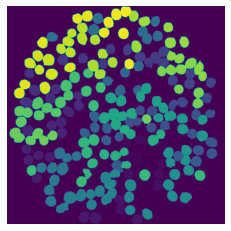

copy img to training:  IMG_20150819_133350
copy mask to training:  IMG_20150819_133350
copy img to training:  IMG_20150819_134112
copy mask to training:  IMG_20150819_134112
copy img to training:  IMG_20150930_162315
copy mask to training:  IMG_20150930_162315
copy img to training:  IMG_20150930_161825
copy mask to training:  IMG_20150930_161825
copy img to test:  IMG_20150930_163018
copy mask to test:  IMG_20150930_163018
../data/fit_to_circle/test/cropped_P76_IMG_20150930_163018_masks.png
<class 'numpy.ndarray'> (1024, 1024)


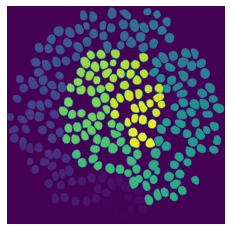

copy img to training:  IMG_20150930_163156
copy mask to training:  IMG_20150930_163156
copy img to training:  IMG_20150930_162038
copy mask to training:  IMG_20150930_162038
copy img to training:  IMG_20150819_121456
copy mask to training:  IMG_20150819_121456
copy img to training:  IMG_20150819_115417
copy mask to training:  IMG_20150819_115417
copy img to training:  IMG_20150819_121240
copy mask to training:  IMG_20150819_121240
copy img to test:  IMG_20150819_121053
copy mask to test:  IMG_20150819_121053
../data/fit_to_circle/test/cropped_P28_IMG_20150819_121053_masks.png
<class 'numpy.ndarray'> (1024, 1024)


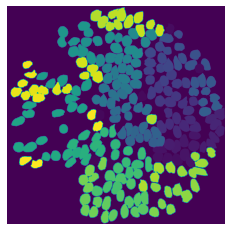

copy img to training:  IMG_20150819_115955
copy mask to training:  IMG_20150819_115955
copy img to training:  IMG_20150611_104609
copy mask to training:  IMG_20150611_104609
copy img to training:  IMG_20150611_104510
copy mask to training:  IMG_20150611_104510
copy img to training:  IMG_20150611_104404
copy mask to training:  IMG_20150611_104404
copy img to training:  IMG_20150611_104753
copy mask to training:  IMG_20150611_104753
copy img to test:  IMG_20150611_104824
copy mask to test:  IMG_20150611_104824
../data/fit_to_circle/test/cropped_P208_IMG_20150611_104824_masks.png
<class 'numpy.ndarray'> (1024, 1024)


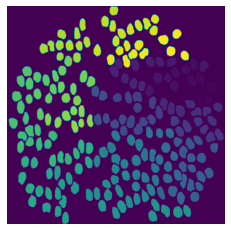

copy img to training:  IMG_20151207_114605
copy mask to training:  IMG_20151207_114605
copy img to test:  IMG_20151207_114345
copy mask to test:  IMG_20151207_114345
../data/fit_to_circle/test/cropped_P209_IMG_20151207_114345_masks.png
<class 'numpy.ndarray'> (1024, 1024)


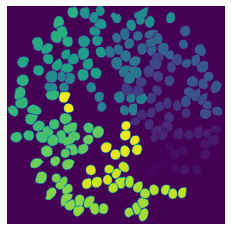

copy img to training:  IMG_20151207_114038
copy mask to training:  IMG_20151207_114038
copy img to training:  IMG_20151207_114653
copy mask to training:  IMG_20151207_114653
copy img to training:  IMG_20151207_114444
copy mask to training:  IMG_20151207_114444
copy img to training:  IMG_20150714_093636
copy mask to training:  IMG_20150714_093636
copy img to training:  IMG_20150714_093600
copy mask to training:  IMG_20150714_093600
copy img to training:  IMG_20150714_093806
copy mask to training:  IMG_20150714_093806
copy img to test:  IMG_20150714_093715
copy mask to test:  IMG_20150714_093715
../data/fit_to_circle/test/cropped_P8_IMG_20150714_093715_masks.png
<class 'numpy.ndarray'> (1024, 1024)


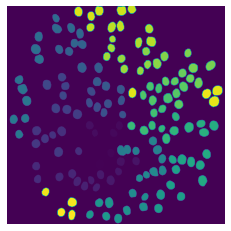

copy img to training:  IMG_20150714_093512
copy mask to training:  IMG_20150714_093512
copy img to training:  IMG_20150813_131330
copy mask to training:  IMG_20150813_131330
copy img to test:  IMG_20150813_130332
copy mask to test:  IMG_20150813_130332
../data/fit_to_circle/test/cropped_P31_IMG_20150813_130332_masks.png
<class 'numpy.ndarray'> (1024, 1024)


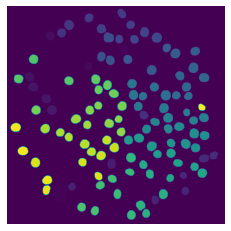

copy img to training:  IMG_20150813_130849
copy mask to training:  IMG_20150813_130849
copy img to training:  IMG_20150813_130510
copy mask to training:  IMG_20150813_130510
copy img to training:  IMG_20150813_131022
copy mask to training:  IMG_20150813_131022
copy img to training:  IMG_20150821_165118
copy mask to training:  IMG_20150821_165118
copy img to training:  IMG_20150821_170403
copy mask to training:  IMG_20150821_170403
copy img to test:  IMG_20150821_170021
copy mask to test:  IMG_20150821_170021
../data/fit_to_circle/test/cropped_P55_IMG_20150821_170021_masks.png
<class 'numpy.ndarray'> (1024, 1024)


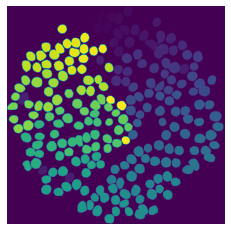

copy img to training:  IMG_20150821_170249
copy mask to training:  IMG_20150821_170249
copy img to training:  IMG_20150821_165519
copy mask to training:  IMG_20150821_165519
copy img to training:  IMG_20150729_104027
copy mask to training:  IMG_20150729_104027
copy img to training:  IMG_20150729_110134
copy mask to training:  IMG_20150729_110134
copy img to training:  IMG_20150729_110305
copy mask to training:  IMG_20150729_110305
copy img to test:  IMG_20150729_111518
copy mask to test:  IMG_20150729_111518
../data/fit_to_circle/test/cropped_P18_IMG_20150729_111518_masks.png
<class 'numpy.ndarray'> (1024, 1024)


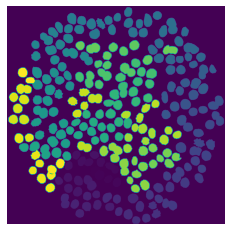

copy img to training:  IMG_20150729_110457
copy mask to training:  IMG_20150729_110457
copy img to training:  IMG_20150813_162016
copy mask to training:  IMG_20150813_162016
copy img to test:  IMG_20150813_163120
copy mask to test:  IMG_20150813_163120
../data/fit_to_circle/test/cropped_P32_IMG_20150813_163120_masks.png
<class 'numpy.ndarray'> (1024, 1024)


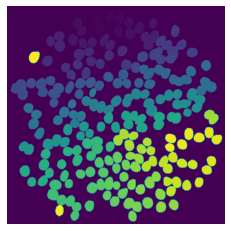

copy img to training:  IMG_20150813_161634
copy mask to training:  IMG_20150813_161634
copy img to training:  IMG_20150813_162554
copy mask to training:  IMG_20150813_162554
copy img to training:  IMG_20150813_162146
copy mask to training:  IMG_20150813_162146
copy img to training:  IMG_20151119_143039
copy mask to training:  IMG_20151119_143039
copy img to test:  IMG_20151118_163539
copy mask to test:  IMG_20151118_163539
../data/fit_to_circle/test/cropped_P130_IMG_20151118_163539_masks.png
<class 'numpy.ndarray'> (1024, 1024)


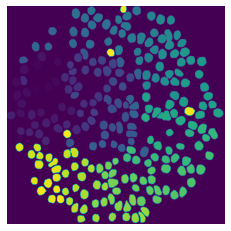

copy img to training:  IMG_20151119_143212
copy mask to training:  IMG_20151119_143212
copy img to training:  IMG_20151118_172913
copy mask to training:  IMG_20151118_172913
copy img to training:  IMG_20151118_173039
copy mask to training:  IMG_20151118_173039
len counter:  165
len counter_train:  132
len counter_test:  33


In [139]:
dict_img_path_fit2circle = dict(zip(df['img_path'], df['img_path_fit2circle']))
dict_mask_path_fit2circle = dict(zip(df['img_path'], df['mask_path_fit2circle']))
dict_patient_n = dict(zip(df['img_path'], df['patient_n_path']))
dict_filename = dict(zip(df['img_path'], df['filename']))

counter = 0
counter_train = 0
counter_test = 0
resize = 1024

outdir_test = f'../data/fit_to_circle/test'
outdir_train = f'../data/fit_to_circle/train'
check_if_outdir_test = os.path.isdir(outdir_test)
check_if_outdir_train = os.path.isdir(outdir_train)
if not check_if_outdir_test:
    os.makedirs(outdir_test)
if not check_if_outdir_train:
    os.makedirs(outdir_train)

for img_path in df.loc[(df['annotation_type'] == 'Polygon'), 'img_path'].unique():
    counter += 1

    patient_n_path = dict_patient_n[img_path]
    filename = dict_filename[img_path]
    img_path_fit2circle = dict_img_path_fit2circle[img_path]
    mask_path_fit2circle = dict_mask_path_fit2circle[img_path]
    
    # copy to train folder
    if not df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path) & (df['train_test'] == 'train'), 'img_path'].empty:
        counter_train += 1
        print('copy img to training: ', filename)
        img = cv2.imread(img_path_fit2circle, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (resize, resize))
        outname_img = os.path.join(outdir_train + '/cropped_P' +  str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_img, img)
        print('copy mask to training: ', filename)
        mask = cv2.imread(mask_path_fit2circle, cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (resize, resize))
        outname_mask = os.path.join(outdir_train + '/cropped_P' +  str(patient_n_path) + '_' + filename + '_masks.png')
        cv2.imwrite(outname_mask, mask)
        
    # copy to test folder
    if not df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path) & (df['train_test'] == 'test'), 'img_path'].empty:
        counter_test +=1
        print('copy img to test: ', filename)
        img = cv2.imread(img_path_fit2circle, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (resize, resize))
        outname_img = os.path.join(outdir_test + '/cropped_P' +   str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_img, img)
        print('copy mask to test: ', filename)
        mask = cv2.imread(mask_path_fit2circle,cv2.IMREAD_UNCHANGED )
        mask = cv2.resize(mask, (resize, resize))
        outname_mask = os.path.join(outdir_test + '/cropped_P' +   str(patient_n_path) + '_' + filename + '_masks.png')
        cv2.imwrite(outname_mask, mask)

        
print('len counter: ', counter)
print('len counter_train: ', counter_train)
print('len counter_test: ', counter_test)


In [97]:
dict_img_path_fit2circle = dict(zip(df['img_path'], df['img_path_fit2circle']))
dict_mask_path_fit2circle = dict(zip(df['img_path'], df['mask_path_fit2circle']))
dict_patient_n = dict(zip(df['img_path'], df['patient_n_path']))
dict_filename = dict(zip(df['img_path'], df['filename']))

counter = 0
counter_train = 0
counter_test = 0
resize = 512

outdir_test_img = f'../data/fit_to_circle/test_img'
outdir_train_img = f'../data/fit_to_circle/train_img'
outdir_test_mask = f'../data/fit_to_circle/test_mask'
outdir_train_mask = f'../data/fit_to_circle/train_mask'
check_if_outdir_test_img = os.path.isdir(outdir_test_img)
check_if_outdir_train_img = os.path.isdir(outdir_train_img)
check_if_outdir_test_mask = os.path.isdir(outdir_test_mask)
check_if_outdir_train_mask = os.path.isdir(outdir_train_mask)
if not check_if_outdir_test_img:
    os.makedirs(outdir_test_img)
if not check_if_outdir_train_img:
    os.makedirs(outdir_train_img)
if not check_if_outdir_test_mask:
    os.makedirs(outdir_test_mask)
if not check_if_outdir_train_mask:
    os.makedirs(outdir_train_mask)
    

for img_path in df.loc[(df['annotation_type'] == 'Polygon'), 'img_path'].unique():
    counter += 1

    patient_n_path = dict_patient_n[img_path]
    filename = dict_filename[img_path]
    img_path_fit2circle = dict_img_path_fit2circle[img_path]
    mask_path_fit2circle = dict_mask_path_fit2circle[img_path]
    
    # copy to train folder
    if not df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path) & (df['train_test'] == 'train'), 'img_path'].empty:
        counter_train += 1
        print('copy img to training: ', filename)
        img = cv2.imread(img_path_fit2circle, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (resize, resize))
        outname_img_train = os.path.join(outdir_train_img + '/cropped_P' + str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_img_train, img)
        print('copy mask to training: ', filename)
        mask = plt.imread(mask_path_fit2circle)
        mask = cv2.resize(mask, (resize, resize))
        outname_mask_train = os.path.join(outdir_train_mask + '/cropped_P' + str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_mask_train, mask)
        
    # copy to test folder
    if not df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path) & (df['train_test'] == 'test'), 'img_path'].empty:
        counter_test +=1
        print('copy img to test: ', filename)
        img = cv2.imread(img_path_fit2circle, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (resize, resize))
        outname_img_test = os.path.join(outdir_test_img + '/cropped_P' + str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_img_test, img)
        print('copy mask to test: ', filename)
        mask = plt.imread(mask_path_fit2circle)
        mask = cv2.resize(mask, (resize, resize))
        outname_mask_test = os.path.join(outdir_test_mask + '/cropped_P' + str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_mask_test, mask)
        
print('len counter: ', counter)
print('len counter_train: ', counter_train)
print('len counter_test: ', counter_test)


copy img to training:  IMG_20150817_103139
copy mask to training:  IMG_20150817_103139
copy img to training:  IMG_20150817_103303
copy mask to training:  IMG_20150817_103303
copy img to test:  IMG_20150817_102702
copy mask to test:  IMG_20150817_102702
copy img to training:  IMG_20150817_102823
copy mask to training:  IMG_20150817_102823
copy img to training:  IMG_20150817_103901
copy mask to training:  IMG_20150817_103901
copy img to training:  IMG_20150725_123938
copy mask to training:  IMG_20150725_123938
copy img to training:  IMG_20150725_125213
copy mask to training:  IMG_20150725_125213
copy img to training:  IMG_20150725_125847
copy mask to training:  IMG_20150725_125847
copy img to test:  IMG_20150725_124606
copy mask to test:  IMG_20150725_124606
copy img to training:  IMG_20150725_124830
copy mask to training:  IMG_20150725_124830
copy img to training:  IMG_20151004_130810
copy mask to training:  IMG_20151004_130810
copy img to test:  IMG_20151004_130408
copy mask to test:  

copy img to test:  IMG_20151002_144341
copy mask to test:  IMG_20151002_144341
copy img to training:  IMG_20151002_144855
copy mask to training:  IMG_20151002_144855
copy img to training:  IMG_20151002_145014
copy mask to training:  IMG_20151002_145014
copy img to training:  IMG_20151002_145330
copy mask to training:  IMG_20151002_145330
copy img to training:  IMG_20151112_131255
copy mask to training:  IMG_20151112_131255
copy img to test:  IMG_20151112_131622
copy mask to test:  IMG_20151112_131622
copy img to training:  IMG_20151112_131546
copy mask to training:  IMG_20151112_131546
copy img to training:  IMG_20151112_131408
copy mask to training:  IMG_20151112_131408
copy img to training:  IMG_20151112_131731
copy mask to training:  IMG_20151112_131731
copy img to training:  IMG_20151005_121656
copy mask to training:  IMG_20151005_121656
copy img to training:  IMG_20151005_121425
copy mask to training:  IMG_20151005_121425
copy img to test:  IMG_20151005_121554
copy mask to test:  

### Save Polygon to YOLO for Poly Yolo

In [21]:
# produce textfiles for all elements in the train and validation dataset
# FORMAT:
# path_to\image1.jpg x1,y1,x2,y2,class,p1x,p1y,pnx,pny x1,y1,x2,y2,class,p1x,p1y,pnx,pny
previous_row = '1'
file = open('../data/fit_to_circle/poly_yolo_train.txt',"w+")
for img_path_fit_to_circle in df.loc[(df['annotation_type'] == 'Polygon') &  
                                        (df['train_test'] == 'train'), 'img_path_fit2circle'].unique():
    #print(img_path_fit_to_circle)
    file.write(str(img_path_fit_to_circle) + ' ')
    for index, row in df[df['img_path_fit2circle'] == img_path_fit_to_circle].iterrows():
        if row is not previous_row:
            file.write(str(row['adjusted_bbx'][0]) + ',' +
                       str(row['adjusted_bbx'][1]) + ',' +
                       str(row['adjusted_bbx'][2]) + ',' +
                       str(row['adjusted_bbx'][3]) + ',' +
                       str(row['cell']) + ','  +
                        ''.join(str(str(poly[0]) + ',' + str(poly[1]) + ',') for poly in row['adjusted_position'])                        + ' ')
    file.write('\n')
    previous_row = row
file.close()

In [22]:
# produce textfiles for all elements in the train and validation dataset
# FORMAT:
# path_to\image1.jpg x1,y1,x2,y2,class,p1x,p1y,pnx,pny x1,y1,x2,y2,class,p1x,p1y,pnx,pny
previous_row = '1'
file = open('../data/fit_to_circle/poly_yolo_test.txt',"w+")
for img_path_fit_to_circle in df.loc[(df['annotation_type'] == 'Polygon') &  
                                        (df['train_test'] == 'test'), 'img_path_fit2circle'].unique():
    #print(img_path_fit_to_circle)
    file.write(str(img_path_fit_to_circle) + ' ')
    for index, row in df[df['img_path_fit2circle'] == img_path_fit_to_circle].iterrows():
        if row is not previous_row:
            file.write(str(row['adjusted_bbx'][0]) + ',' +
                       str(row['adjusted_bbx'][1]) + ',' +
                       str(row['adjusted_bbx'][2]) + ',' +
                       str(row['adjusted_bbx'][3]) + ',' +
                       str(row['cell']) + ','  +
                        ''.join(str(str(poly[0]) + ',' + str(poly[1]) + ',') for poly in row['adjusted_position'])                        + ' ')
    file.write('\n')
    previous_row = row
file.close()